### Extracting video features:

In [4]:
import os
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision.models import video
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from transformers import pipeline
from moviepy.editor import VideoFileClip
import whisper
import easyocr

# pre-trained models
video_model = video.r3d_18(weights=video.R3D_18_Weights.KINETICS400_V1).eval()
object_detection_model = fasterrcnn_resnet50_fpn(weights='DEFAULT').eval()
whisper_model = whisper.load_model("base")
summarizer = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6")
reader = easyocr.Reader(['en'], gpu=True, model_storage_directory='/content/drive/MyDrive/easyocr_models')

def extract_video_features(video_path):
    try:
        cap = cv2.VideoCapture(video_path)
        frames = []
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, (112, 112))
            frame = transforms.ToTensor()(frame)
            frames.append(frame)
        cap.release()

        if len(frames) < 16:
            frames = frames * (16 // len(frames)) + frames[:16 % len(frames)]

        frames = torch.stack(frames[:16]).permute(1, 0, 2, 3).unsqueeze(0)

        with torch.no_grad():
            features = video_model(frames)

        if features.ndim == 5:
            features = features.squeeze().mean(dim=(1, 2, 3))
        elif features.ndim == 4:
            features = features.squeeze().mean(dim=(1, 2))
        elif features.ndim == 2:
            features = features.squeeze()
        else:
            raise ValueError(f"Unexpected features dimension: {features.ndim}")

        features = features.cpu().numpy()

        # Ensure consistent feature size
        if len(features) < 400:
            features = np.pad(features, (0, 400 - len(features)))
        return features[:400]
    except Exception as e:
        print(f"Error extracting features from video {video_path}: {str(e)}")
        return np.zeros(400)  # Return zero vector in case of error

def extract_text_from_video(video_path, frame_sample_rate=90):
    try:
        cap = cv2.VideoCapture(video_path)
        video_text = []
        frame_count = 0

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            if frame_count % frame_sample_rate == 0:
                gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                result = reader.readtext(gray_frame, detail=0)
                video_text.extend(result)
            frame_count += 1

        cap.release()
        return ' '.join(video_text)
    except Exception as e:
        print(f"Error extracting text from video {video_path}: {str(e)}")
        return ""

def generate_video_description(video_path):
    try:
        # Speech-to-text
        audio_filename = os.path.basename(video_path).replace('.mp4', '.wav')
        audio_path = os.path.join('/content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files', audio_filename)
        video = VideoFileClip(video_path)
        video.audio.write_audiofile(audio_path)
        transcription = whisper_model.transcribe(audio_path)['text']

        # Object detection
        cap = cv2.VideoCapture(video_path)
        ret, frame = cap.read()
        cap.release()
        if not ret:
            return "Failed to extract frame from video."

        transform = transforms.Compose([transforms.ToTensor()])
        frame_tensor = transform(frame)
        predictions = object_detection_model([frame_tensor])
        labels = predictions[0]['labels'].detach().numpy()

        # Summarize transcription
        max_length = min(50, max(10, len(transcription.split()) // 2))
        summary = summarizer(transcription, max_length=max_length, min_length=10, do_sample=False)[0]['summary_text']

        description = f"Video Summary: {summary}. Key objects detected: {labels}."
        return description
    except Exception as e:
        print(f"Error processing video {video_path}: {str(e)}")
        return "Error generating video description."

def process_video(video_path):
    try:
        features = extract_video_features(video_path)
        text = extract_text_from_video(video_path)
        description = generate_video_description(video_path)
        return features, text, description
    except Exception as e:
        print(f"Error processing video {video_path}: {str(e)}")
        return np.zeros(400), "", "Error processing video."

Downloading: "https://download.pytorch.org/models/r3d_18-b3b3357e.pth" to /root/.cache/torch/hub/checkpoints/r3d_18-b3b3357e.pth
100%|██████████| 127M/127M [00:00<00:00, 168MB/s]
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 194MB/s]
100%|███████████████████████████████████████| 139M/139M [00:02<00:00, 58.4MiB/s]
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [5]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

  warnings.warn(



config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

### Generating Video description using only Video:

### Model Pipeline and Training:

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from tqdm import tqdm

# Data Loading and Preprocessing
def load_and_preprocess_data():
    sample_data = pd.read_csv('/content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/Sample.csv')
    ground_truth = pd.read_csv('/content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/Ground Truth Form Responses.csv')
    video_text = pd.read_csv('/content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/important_dataframes/video_text_with_senti_scores.csv')
    video_features = pd.read_csv('/content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/important_dataframes/video_features_df.csv')
    video_description = pd.read_csv('/content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/important_dataframes/video_descriptions_df.csv')

    questions = [
        'Is there a call to go online (e.g., shop online, visit the Web)? ',
        'Is there online contact information provided (e.g., URL, website)? ',
        'Is there a visual or verbal call to purchase (e.g., buy now, order now)?',
        'Does the ad portray a sense of urgency to act (e.g., buy before sales ends, order before ends)? ',
        'Is there an incentive to buy (e.g., a discount, a coupon, a sale or "limited time offer")? ',
        'Is there offline contact information provided (e.g., phone, mail, store location)?',
        'Is there mention of something free? ',
        'Does the ad mention at least one specific product or service (e.g., model, type, item)? ',
        'Is there any verbal or visual mention of the price?',
        'Does the ad show the brand (logo, brand name) or trademark (something that most people know is the brand) multiple times?\n\nFor example, Nike ads often have the "swoosh" logo prominently displayed on shoes and apparel worn by celebrity athletes. The "Just Do It" slogan is another Nike trademark frequently included.',
        'Does the ad show the brand or trademark exactly once at the end of the ad?',
        'Is the ad intended to affect the viewer emotionally, either with positive emotion (fun, joy), negative emotion (sad, anxious) or another type of emotion? (Note: You may not personally agree, but assess if that was the intention.)',
        'Does the ad give you a positive feeling about the brand? ',
        'Does the ad have a story arc, with a beginning and an end? ',
        'Does the ad have a reversal of fortune, where something changes for the better, or changes for the worse?',
        'Does the ad have relatable characters? ',
        'Is the ad creative/clever?',
        'Is the ad intended to be funny? (Note: You may not personally agree, but assess if that was the intention.) ',
        'Does this ad provide sensory stimulation (e.g., cool visuals, arousing music, mouth-watering)? ',
        'Is the ad visually pleasing?',
        'Does the ad have cute elements like animals, babies, animated, characters, etc?'
    ]

    # Aggregate ground truth data
    for col in questions:
        ground_truth[col] = ground_truth[col].str.lower().isin(['yes', 'yes, both', 'yes, visual']).astype(int)
    aggregated_ground_truth = ground_truth.groupby('creative_data_id')[questions].mean()
    aggregated_ground_truth = (aggregated_ground_truth >= 0.5).astype(int)

    # Merge all data
    merged_data = sample_data.merge(aggregated_ground_truth, left_on='creative_data_id', right_index=True, how='inner')
    merged_data = merged_data.merge(video_text, on='creative_data_id', how='inner')
    merged_data = merged_data.merge(video_features, on='creative_data_id', how='inner')

    # Combine text features
    merged_data['text_features'] = merged_data['creative_data_description'] + ' ' + merged_data['speech']

    # Prepare numerical features
    numerical_feature_columns = ['creative_data_duration', 'creative_data_lifetime_spend_estimated',
                                'creative_data_lifetime_airings_count', 'sentiment_score'] + video_features.columns[1:].tolist()

    # Normalize numerical features
    scaler = StandardScaler()
    merged_data[numerical_feature_columns] = scaler.fit_transform(merged_data[numerical_feature_columns])

    return merged_data, numerical_feature_columns, questions

# Model Architecture
class VideoAdClassifier(nn.Module):
    def __init__(self, bert_model, num_numerical_features, num_classes):
        super(VideoAdClassifier, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size + num_numerical_features, num_classes)

    def forward(self, input_ids, attention_mask, numerical_features):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[0][:, 0]  # Use the [CLS] token representation
        combined_features = torch.cat((pooled_output, numerical_features), dim=1)
        x = self.dropout(combined_features)
        logits = self.fc(x)
        return logits

# Data Preparation
def prepare_dataloader(data, tokenizer, numerical_features, questions, batch_size=16):
    inputs = tokenizer(data['text_features'].tolist(), padding=True, truncation=True, max_length=512, return_tensors="pt")
    numerical_inputs = torch.tensor(data[numerical_features].values, dtype=torch.float)
    labels = torch.tensor(data[questions].values, dtype=torch.float)

    dataset = TensorDataset(inputs['input_ids'], inputs['attention_mask'], numerical_inputs, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

# Training Function
def train_model(model, train_dataloader, val_dataloader, num_epochs, device):
    optimizer = AdamW(model.parameters(), lr=2e-5)
    criterion = nn.BCEWithLogitsLoss()

    best_val_f1 = 0
    for epoch in range(num_epochs):
        model.train()
        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            batch = [b.to(device) for b in batch]
            input_ids, attention_mask, numerical_features, labels = batch

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask, numerical_features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_predictions, val_labels = [], []
        with torch.no_grad():
            for batch in val_dataloader:
                batch = [b.to(device) for b in batch]
                input_ids, attention_mask, numerical_features, labels = batch

                outputs = model(input_ids, attention_mask, numerical_features)
                val_predictions.extend(torch.sigmoid(outputs).cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_f1 = f1_score(val_labels, (np.array(val_predictions) > 0.5).astype(int), average='micro')
        print(f"Epoch {epoch+1}/{num_epochs}, Validation F1: {val_f1:.4f}")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), 'best_model.pth')

    return model

# Main Execution
if __name__ == '__main__':
    data, numerical_features, questions = load_and_preprocess_data()

    # Use a smaller and faster model
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

    # Split the data
    train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

    train_dataloader = prepare_dataloader(train_data, tokenizer, numerical_features, questions)
    val_dataloader = prepare_dataloader(val_data, tokenizer, numerical_features, questions)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = VideoAdClassifier(bert_model, len(numerical_features), len(questions)).to(device)

    # Train the model
    model = train_model(model, train_dataloader, val_dataloader, num_epochs=10, device=device)

    # Make predictions on validation set
    model.eval()
    val_predictions = []
    val_labels = []
    with torch.no_grad():
        for batch in val_dataloader:
            batch = [b.to(device) for b in batch]
            input_ids, attention_mask, numerical_features, labels = batch
            outputs = model(input_ids, attention_mask, numerical_features)
            val_predictions.extend(torch.sigmoid(outputs).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    # Convert predictions to binary
    val_predictions = (np.array(val_predictions) > 0.5).astype(int)
    val_labels = np.array(val_labels)

    # Calculate metrics
    agreement = np.mean(val_labels == val_predictions)
    f1 = f1_score(val_labels, val_predictions, average='micro')
    precision = precision_score(val_labels, val_predictions, average='micro')
    recall = recall_score(val_labels, val_predictions, average='micro')

    print(f"Agreement: {agreement:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    # Save predictions
    val_data[questions] = val_predictions
    val_data[['creative_data_id'] + questions].to_csv('predictions.csv', index=True)

Epoch 1/10: 100%|██████████| 8/8 [02:52<00:00, 21.54s/it]


Epoch 1/10, Validation F1: 0.6890


Epoch 2/10: 100%|██████████| 8/8 [02:43<00:00, 20.44s/it]


Epoch 2/10, Validation F1: 0.7023


Epoch 3/10: 100%|██████████| 8/8 [02:43<00:00, 20.46s/it]


Epoch 3/10, Validation F1: 0.6974


Epoch 4/10: 100%|██████████| 8/8 [02:47<00:00, 20.94s/it]


Epoch 4/10, Validation F1: 0.7010


Epoch 5/10: 100%|██████████| 8/8 [02:54<00:00, 21.87s/it]


Epoch 5/10, Validation F1: 0.6998


Epoch 6/10: 100%|██████████| 8/8 [03:50<00:00, 28.80s/it]


Epoch 6/10, Validation F1: 0.7273


Epoch 7/10: 100%|██████████| 8/8 [02:51<00:00, 21.40s/it]


Epoch 7/10, Validation F1: 0.7381


Epoch 8/10: 100%|██████████| 8/8 [03:08<00:00, 23.60s/it]


Epoch 8/10, Validation F1: 0.7361


Epoch 9/10: 100%|██████████| 8/8 [02:53<00:00, 21.63s/it]


Epoch 9/10, Validation F1: 0.7475


Epoch 10/10: 100%|██████████| 8/8 [02:55<00:00, 21.95s/it]


Epoch 10/10, Validation F1: 0.7374
Agreement: 0.7524
F1 Score: 0.7374
Precision: 0.7766
Recall: 0.7019


### Saving the model:

In [6]:
def get_optimizer(model):
    return AdamW(model.parameters(), lr=2e-5)

In [7]:
def save_model_and_optimizer(model, save_path):
    optimizer = get_optimizer(model)
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, save_path)
    print(f"Model and optimizer saved to {save_path}")

In [ ]:
# Assuming 'model' is your trained model
save_path = '/content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/final_model/video_ad_model.pth'
save_model_and_optimizer(model, save_path)

Model and optimizer saved to /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/final_model/video_ad_model.pth


### Loading the model:

In [8]:
def load_model_and_optimizer(model, filepath, device):
    checkpoint = torch.load(filepath, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer = get_optimizer(model)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return model, optimizer

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VideoAdClassifier(bert_model, len(numerical_features), len(questions)).to(device)
filepath = '/content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/final_model/video_ad_model.pth'
model, optimizer = load_model_and_optimizer(model, filepath, device)
model.eval()  # Set the model to evaluation mode

VideoAdClassifier(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linea

### F1 Score for each question:

In [37]:
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from tqdm import tqdm

def load_model_and_optimizer(model, filepath, device):
    checkpoint = torch.load(filepath, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer = get_optimizer(model)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return model, optimizer

def get_optimizer(model):
    return AdamW(model.parameters(), lr=2e-5)

def prepare_input(row, tokenizer, numerical_features):
    text_input = tokenizer(row['text_features'], padding=True, truncation=True, max_length=512, return_tensors="pt")
    numerical_input = torch.tensor(row[numerical_features].values.astype(np.float32)).unsqueeze(0)
    return text_input, numerical_input

def predict_and_evaluate(model, data, tokenizer, numerical_features, questions, device):
    model.eval()
    all_predictions = []
    all_true_labels = []

    for _, row in tqdm(data.iterrows(), total=len(data)):
        text_input, numerical_input = prepare_input(row, tokenizer, numerical_features)

        with torch.no_grad():
            outputs = model(text_input['input_ids'].to(device), text_input['attention_mask'].to(device), numerical_input.to(device))
            predictions = torch.sigmoid(outputs).cpu().numpy()

        all_predictions.append((predictions > 0.5).astype(int)[0])
        all_true_labels.append(row[questions].values.astype(int))

    return np.array(all_predictions), np.array(all_true_labels)

# Load data
data, numerical_features, questions = load_and_preprocess_data()

# Load model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VideoAdClassifier(bert_model, len(numerical_features), len(questions)).to(device)
filepath = '/content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/final_model/video_ad_model.pth'
model, optimizer = load_model_and_optimizer(model, filepath, device)

# Make predictions and get true labels
predictions, true_labels = predict_and_evaluate(model, data, tokenizer, numerical_features, questions, device)

# Calculate F1 score for each question
for i, question in enumerate(questions):
    f1 = f1_score(true_labels[:, i], predictions[:, i])
    print(f"{question} -> F1 Score: {f1:.4f}")

# Calculate overall metrics
overall_f1 = f1_score(true_labels, predictions, average='micro')
overall_precision = precision_score(true_labels, predictions, average='micro')
overall_recall = recall_score(true_labels, predictions, average='micro')
overall_accuracy = accuracy_score(true_labels.flatten(), predictions.flatten())

print("\nOverall Metrics:")
print(f"F1 Score: {overall_f1:.4f}")
print(f"Precision: {overall_precision:.4f}")
print(f"Recall: {overall_recall:.4f}")
print(f"Accuracy: {overall_accuracy:.4f}")

# Save predictions
predictions_df = pd.DataFrame(predictions, columns=questions)
predictions_df.insert(0, 'creative_data_id', data['creative_data_id'])
predictions_df.to_csv('predictions.csv', index=False)
print("\nPredictions saved to 'predictions.csv'")

100%|██████████| 150/150 [00:01<00:00, 99.63it/s] 

Is there a call to go online (e.g., shop online, visit the Web)?  -> F1 Score: 0.3273
Is there online contact information provided (e.g., URL, website)?  -> F1 Score: 0.6000
Is there a visual or verbal call to purchase (e.g., buy now, order now)? -> F1 Score: 0.8119
Does the ad portray a sense of urgency to act (e.g., buy before sales ends, order before ends)?  -> F1 Score: 0.7838
Is there an incentive to buy (e.g., a discount, a coupon, a sale or "limited time offer")?  -> F1 Score: 0.8413
Is there offline contact information provided (e.g., phone, mail, store location)? -> F1 Score: 0.2581
Is there mention of something free?  -> F1 Score: 0.0000
Does the ad mention at least one specific product or service (e.g., model, type, item)?  -> F1 Score: 0.9281
Is there any verbal or visual mention of the price? -> F1 Score: 0.8269
Does the ad show the brand (logo, brand name) or trademark (something that most people know is the brand) multiple times?

For example, Nike ads often have the "sw

In [43]:
# Convert numerical predictions to 'yes' and 'no'
predictions_yes_no = np.where(predictions == 1, 'yes', 'no')

# Create a DataFrame with the desired format
output_df = pd.DataFrame({
    'creative_data_id': data['creative_data_id']
})

# Add columns for each question using the actual question text
for i, question in enumerate(questions):
    output_df[question] = predictions_yes_no[:, i]

# Save the DataFrame to a CSV file
output_file_path = '/content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/final_model/predictions_formatted_final.csv'
output_df.to_csv(output_file_path, index=False)

print(f"\nPredictions saved in the specified format to '{output_file_path}'")

# Display the first few rows of the formatted predictions
print("\nFirst few rows of the formatted predictions:")
print(output_df.head().to_string(index=False))


Predictions saved in the specified format to '/content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/final_model/predictions_formatted_final.csv'

First few rows of the formatted predictions:
 creative_data_id Is there a call to go online (e.g., shop online, visit the Web)?  Is there online contact information provided (e.g., URL, website)?  Is there a visual or verbal call to purchase (e.g., buy now, order now)? Does the ad portray a sense of urgency to act (e.g., buy before sales ends, order before ends)?  Is there an incentive to buy (e.g., a discount, a coupon, a sale or "limited time offer")?  Is there offline contact information provided (e.g., phone, mail, store location)? Is there mention of something free?  Does the ad mention at least one specific product or service (e.g., model, type, item)?  Is there any verbal or visual mention of the price? Does the ad show the brand (logo, brand name) or trademark (something that most people know is the brand) multiple time

In [44]:
output_df.shape

(150, 22)

### Predicting for all videos & creating prediction csv:

In [ ]:
!pip install git+https://github.com/openai/whisper.git


In [ ]:
import os
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from tqdm import tqdm
import csv

def predict_all_videos(model, tokenizer, numerical_features, questions, video_dir, csv_path):
    model.eval()

    # Create CSV file and write header
    with open(csv_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['creative_data_id'] + questions)

    for video_file in tqdm(os.listdir(video_dir)):
        if video_file.endswith('.mp4'):
            video_path = os.path.join(video_dir, video_file)
            video_id = os.path.splitext(video_file)[0]  # Corrected this line

            try:
                # Extract features, text, and description
                video_features = extract_video_features(video_path)
                video_text = extract_text_from_video(video_path)
                video_description = generate_video_description(video_path)

                # Prepare input
                text_input = tokenizer(video_text + ' ' + video_description, padding=True, truncation=True, max_length=512, return_tensors="pt")
                numerical_input = torch.tensor(video_features, dtype=torch.float).unsqueeze(0)

                # Ensure numerical_input has the correct number of features
                if numerical_input.shape[1] != len(numerical_features):
                    print(f"Mismatch in features for video {video_id}. Expected {len(numerical_features)}, got {numerical_input.shape[1]}.")
                    # Instead of skipping, pad or truncate to match expected size
                    if numerical_input.shape[1] < len(numerical_features):
                        numerical_input = torch.cat([numerical_input, torch.zeros(1, len(numerical_features) - numerical_input.shape[1])], dim=1)
                    else:
                        numerical_input = numerical_input[:, :len(numerical_features)]

                # Make prediction
                with torch.no_grad():
                    outputs = model(text_input['input_ids'].to(device), text_input['attention_mask'].to(device), numerical_input.to(device))
                    predictions = torch.sigmoid(outputs).cpu().numpy()

                # Convert predictions to binary (0 or 1)
                binary_predictions = (predictions > 0.5).astype(int)[0]

                # Append predictions to CSV
                with open(csv_path, 'a', newline='') as csvfile:
                    writer = csv.writer(csvfile)
                    writer.writerow([video_id] + binary_predictions.tolist())

            except Exception as e:
                print(f"Error processing video {video_id}: {str(e)}")
                # Add a row of zeros for failed predictions to maintain consistency
                with open(csv_path, 'a', newline='') as csvfile:
                    writer = csv.writer(csvfile)
                    writer.writerow([video_id] + [0] * len(questions))

    print(f"Predictions saved to {csv_path}")

    # Read the CSV file back into a DataFrame
    predictions_df = pd.read_csv(csv_path)
    return predictions_df

# Directory containing all videos
video_dir = '/content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/sample'

# Load the trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VideoAdClassifier(bert_model, len(numerical_features), len(questions)).to(device)
filepath = '/content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/final_model/video_ad_model.pth'
model, optimizer = load_model_and_optimizer(model, filepath, device)
model.eval()  # Set the model to evaluation mode

# Path for the CSV file
csv_path = '/content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/final_model/predictions.csv'

# Make predictions for all videos and save to CSV
predictions_df = predict_all_videos(model, tokenizer, numerical_features, questions, video_dir, csv_path)

# Print shape and first few rows of predictions_df
print("Shape of predictions_df:", predictions_df.shape)
print("\nFirst few rows of predictions_df:")
print(predictions_df.head())



  0%|          | 0/151 [00:00<?, ?it/s]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,

  0%|          | 0/151 [00:05<?, ?it/s]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2194673.wav



  0%|          | 0/151 [00:06<?, ?it/s]

MoviePy - Done.


  1%|          | 1/151 [00:12<32:23, 12.96s/it]

Mismatch in features for video 2194673. Expected 404, got 400.


  return F.conv2d(input, weight, bias, self.stride,

  1%|          | 1/151 [00:18<32:23, 12.96s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2142915.wav



  1%|          | 1/151 [00:19<32:23, 12.96s/it]

MoviePy - Done.


  1%|▏         | 2/151 [00:21<26:12, 10.55s/it]

Mismatch in features for video 2142915. Expected 404, got 400.


  return F.conv2d(input, weight, bias, self.stride,

  1%|▏         | 2/151 [00:26<26:12, 10.55s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/1702851.wav



  1%|▏         | 2/151 [00:27<26:12, 10.55s/it]

MoviePy - Done.


  2%|▏         | 3/151 [00:32<26:41, 10.82s/it]

Mismatch in features for video 1702851. Expected 404, got 400.


  return F.conv2d(input, weight, bias, self.stride,

  2%|▏         | 3/151 [00:37<26:41, 10.82s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/1671980.wav



chunk:  58%|█████▊    | 384/663 [00:00<00:00, 787.78it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/audio/io/readers.py:197: UserWarning: Error in file /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/sample/1671980.mp4, At time t=29.98-30.03 seconds, indices wanted: 99671-101668, but len(buffer)=99672
index 99672 is out of bounds for axis 0 with size 99672
  warnings.warn("Error in file %s, "%(self.filename)+


  2%|▏         | 3/151 [00:38<26:41, 10.82s/it]

MoviePy - Done.


  3%|▎         | 4/151 [00:43<26:03, 10.64s/it]

Mismatch in features for video 1671980. Expected 404, got 400.


  return F.conv2d(input, weight, bias, self.stride,

  3%|▎         | 4/151 [00:50<26:03, 10.64s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2381477.wav



  3%|▎         | 4/151 [00:51<26:03, 10.64s/it]

MoviePy - Done.


  3%|▎         | 5/151 [00:56<27:59, 11.51s/it]

Mismatch in features for video 2381477. Expected 404, got 400.


  3%|▎         | 5/151 [01:00<27:59, 11.51s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/1749291.wav



  3%|▎         | 5/151 [01:01<27:59, 11.51s/it]

MoviePy - Done.


  4%|▍         | 6/151 [01:06<27:02, 11.19s/it]

Mismatch in features for video 1749291. Expected 404, got 400.


  4%|▍         | 6/151 [01:11<27:02, 11.19s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/1667694.wav



  4%|▍         | 6/151 [01:12<27:02, 11.19s/it]

MoviePy - Done.


  5%|▍         | 7/151 [01:17<26:33, 11.07s/it]

Mismatch in features for video 1667694. Expected 404, got 400.


  5%|▍         | 7/151 [01:27<26:33, 11.07s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2764983.wav



  5%|▍         | 7/151 [01:28<26:33, 11.07s/it]

MoviePy - Done.


  5%|▌         | 8/151 [01:31<28:41, 12.04s/it]

Mismatch in features for video 2764983. Expected 404, got 400.


  return F.conv2d(input, weight, bias, self.stride,

  5%|▌         | 8/151 [01:37<28:41, 12.04s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2807978.wav



  5%|▌         | 8/151 [01:38<28:41, 12.04s/it]

MoviePy - Done.


  6%|▌         | 9/151 [01:41<26:57, 11.39s/it]

Mismatch in features for video 2807978. Expected 404, got 400.


  return F.conv2d(input, weight, bias, self.stride,

  6%|▌         | 9/151 [01:46<26:57, 11.39s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/3212463.wav



  6%|▌         | 9/151 [01:47<26:57, 11.39s/it]

MoviePy - Done.


  7%|▋         | 10/151 [01:52<26:27, 11.26s/it]

Mismatch in features for video 3212463. Expected 404, got 400.


  return F.conv2d(input, weight, bias, self.stride,

  7%|▋         | 10/151 [01:58<26:27, 11.26s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2379465.wav



  7%|▋         | 10/151 [01:59<26:27, 11.26s/it]

MoviePy - Done.


  7%|▋         | 11/151 [02:03<26:13, 11.24s/it]

Mismatch in features for video 2379465. Expected 404, got 400.


  7%|▋         | 11/151 [02:08<26:13, 11.24s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/1488315.wav



  7%|▋         | 11/151 [02:09<26:13, 11.24s/it]

MoviePy - Done.


  8%|▊         | 12/151 [02:12<24:09, 10.43s/it]

Mismatch in features for video 1488315. Expected 404, got 400.


  8%|▊         | 12/151 [02:17<24:09, 10.43s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/3037506.wav



  8%|▊         | 12/151 [02:17<24:09, 10.43s/it]

MoviePy - Done.


  9%|▊         | 13/151 [02:21<23:00, 10.01s/it]

Mismatch in features for video 3037506. Expected 404, got 400.


  9%|▊         | 13/151 [02:25<23:00, 10.01s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/3149347.wav



  9%|▊         | 13/151 [02:26<23:00, 10.01s/it]

MoviePy - Done.


  9%|▉         | 14/151 [02:30<21:46,  9.54s/it]

Mismatch in features for video 3149347. Expected 404, got 400.


  9%|▉         | 14/151 [02:34<21:46,  9.54s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/3414303.wav



  9%|▉         | 14/151 [02:35<21:46,  9.54s/it]

MoviePy - Done.


 10%|▉         | 15/151 [02:39<21:40,  9.56s/it]

Mismatch in features for video 3414303. Expected 404, got 400.


 10%|▉         | 15/151 [02:44<21:40,  9.56s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/1702594.wav



 10%|▉         | 15/151 [02:45<21:40,  9.56s/it]

MoviePy - Done.


 11%|█         | 16/151 [02:49<21:23,  9.50s/it]

Mismatch in features for video 1702594. Expected 404, got 400.


 11%|█         | 16/151 [02:53<21:23,  9.50s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/1471363.wav



chunk:  96%|█████████▌| 638/663 [00:00<00:00, 955.46it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/audio/io/readers.py:197: UserWarning: Error in file /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/sample/1471363.mp4, At time t=29.98-30.03 seconds, indices wanted: 99671-101668, but len(buffer)=99672
index 99672 is out of bounds for axis 0 with size 99672
  warnings.warn("Error in file %s, "%(self.filename)+


 11%|█         | 16/151 [02:54<21:23,  9.50s/it]

MoviePy - Done.


 11%|█▏        | 17/151 [02:57<20:37,  9.24s/it]

Mismatch in features for video 1471363. Expected 404, got 400.


 11%|█▏        | 17/151 [03:01<20:37,  9.24s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/3119347.wav



 11%|█▏        | 17/151 [03:02<20:37,  9.24s/it]

MoviePy - Done.


 12%|█▏        | 18/151 [03:07<20:43,  9.35s/it]

Mismatch in features for video 3119347. Expected 404, got 400.


  return F.conv2d(input, weight, bias, self.stride,

 12%|█▏        | 18/151 [03:12<20:43,  9.35s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/3078623.wav



 12%|█▏        | 18/151 [03:12<20:43,  9.35s/it]

MoviePy - Done.


 13%|█▎        | 19/151 [03:18<21:59, 10.00s/it]

Mismatch in features for video 3078623. Expected 404, got 400.


 13%|█▎        | 19/151 [03:23<21:59, 10.00s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2076630.wav



chunk:  61%|██████    | 402/663 [00:00<00:00, 636.83it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/audio/io/readers.py:197: UserWarning: Error in file /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/sample/2076630.mp4, At time t=29.98-30.03 seconds, indices wanted: 99671-101668, but len(buffer)=99672
index 99672 is out of bounds for axis 0 with size 99672
  warnings.warn("Error in file %s, "%(self.filename)+


 13%|█▎        | 19/151 [03:24<21:59, 10.00s/it]

MoviePy - Done.


 13%|█▎        | 20/151 [03:28<21:41,  9.93s/it]

Mismatch in features for video 2076630. Expected 404, got 400.


 13%|█▎        | 20/151 [03:32<21:41,  9.93s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2002557.wav



 13%|█▎        | 20/151 [03:33<21:41,  9.93s/it]

MoviePy - Done.


 14%|█▍        | 21/151 [03:38<21:14,  9.81s/it]

Mismatch in features for video 2002557. Expected 404, got 400.


 14%|█▍        | 21/151 [03:43<21:14,  9.81s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/1747914.wav



 14%|█▍        | 21/151 [03:43<21:14,  9.81s/it]

MoviePy - Done.


 15%|█▍        | 22/151 [03:47<20:59,  9.76s/it]

Mismatch in features for video 1747914. Expected 404, got 400.


 15%|█▍        | 22/151 [03:52<20:59,  9.76s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/1776082.wav



 15%|█▍        | 22/151 [03:52<20:59,  9.76s/it]

MoviePy - Done.


 15%|█▌        | 23/151 [03:56<19:56,  9.35s/it]

Mismatch in features for video 1776082. Expected 404, got 400.


  return F.conv2d(input, weight, bias, self.stride,

 15%|█▌        | 23/151 [04:01<19:56,  9.35s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/3339840.wav



 15%|█▌        | 23/151 [04:02<19:56,  9.35s/it]

MoviePy - Done.


 16%|█▌        | 24/151 [04:09<22:25, 10.60s/it]

Mismatch in features for video 3339840. Expected 404, got 400.


 16%|█▌        | 24/151 [04:13<22:25, 10.60s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/1942611.wav



 16%|█▌        | 24/151 [04:14<22:25, 10.60s/it]

MoviePy - Done.


 17%|█▋        | 25/151 [04:18<21:21, 10.17s/it]

Mismatch in features for video 1942611. Expected 404, got 400.


 17%|█▋        | 25/151 [04:26<21:21, 10.17s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/1678735.wav



 17%|█▋        | 25/151 [04:27<21:21, 10.17s/it]

MoviePy - Done.


 17%|█▋        | 26/151 [04:31<22:43, 10.90s/it]

Mismatch in features for video 1678735. Expected 404, got 400.


 17%|█▋        | 26/151 [04:35<22:43, 10.90s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/1930720.wav



 17%|█▋        | 26/151 [04:36<22:43, 10.90s/it]

MoviePy - Done.


 18%|█▊        | 27/151 [04:39<20:38,  9.99s/it]

Mismatch in features for video 1930720. Expected 404, got 400.


 18%|█▊        | 27/151 [04:43<20:38,  9.99s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/3340369.wav



 18%|█▊        | 27/151 [04:44<20:38,  9.99s/it]

MoviePy - Done.


 19%|█▊        | 28/151 [04:47<19:20,  9.43s/it]

Mismatch in features for video 3340369. Expected 404, got 400.


  return F.conv2d(input, weight, bias, self.stride,

 19%|█▊        | 28/151 [04:52<19:20,  9.43s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/1942695.wav



 19%|█▊        | 28/151 [04:53<19:20,  9.43s/it]

MoviePy - Done.


 19%|█▉        | 29/151 [04:57<19:33,  9.62s/it]

Mismatch in features for video 1942695. Expected 404, got 400.


 19%|█▉        | 29/151 [05:02<19:33,  9.62s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/1624211.wav



 19%|█▉        | 29/151 [05:02<19:33,  9.62s/it]

MoviePy - Done.


 20%|█▉        | 30/151 [05:08<20:05,  9.96s/it]

Mismatch in features for video 1624211. Expected 404, got 400.


 20%|█▉        | 30/151 [05:11<20:05,  9.96s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/1768584.wav



 20%|█▉        | 30/151 [05:12<20:05,  9.96s/it]

MoviePy - Done.


 21%|██        | 31/151 [05:16<19:00,  9.51s/it]

Mismatch in features for video 1768584. Expected 404, got 400.


 21%|██        | 31/151 [05:21<19:00,  9.51s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/1733728.wav



 21%|██        | 31/151 [05:22<19:00,  9.51s/it]

MoviePy - Done.


 21%|██        | 32/151 [05:26<19:08,  9.65s/it]

Mismatch in features for video 1733728. Expected 404, got 400.


 21%|██        | 32/151 [05:30<19:08,  9.65s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2327954.wav



 21%|██        | 32/151 [05:31<19:08,  9.65s/it]

MoviePy - Done.


 22%|██▏       | 33/151 [05:36<18:59,  9.66s/it]

Mismatch in features for video 2327954. Expected 404, got 400.


 22%|██▏       | 33/151 [05:40<18:59,  9.66s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2270982.wav



 22%|██▏       | 33/151 [05:41<18:59,  9.66s/it]

MoviePy - Done.


 23%|██▎       | 34/151 [05:46<18:59,  9.74s/it]

Mismatch in features for video 2270982. Expected 404, got 400.


 23%|██▎       | 34/151 [05:50<18:59,  9.74s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/1991222.wav



 23%|██▎       | 34/151 [05:51<18:59,  9.74s/it]

MoviePy - Done.


 23%|██▎       | 35/151 [05:56<18:50,  9.75s/it]

Mismatch in features for video 1991222. Expected 404, got 400.


  return F.conv2d(input, weight, bias, self.stride,

 23%|██▎       | 35/151 [06:00<18:50,  9.75s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2808275.wav



 23%|██▎       | 35/151 [06:01<18:50,  9.75s/it]

MoviePy - Done.


 24%|██▍       | 36/151 [06:06<18:52,  9.85s/it]

Mismatch in features for video 2808275. Expected 404, got 400.


 24%|██▍       | 36/151 [06:10<18:52,  9.85s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/1641167.wav



 24%|██▍       | 36/151 [06:11<18:52,  9.85s/it]

MoviePy - Done.


 25%|██▍       | 37/151 [06:14<17:55,  9.43s/it]

Mismatch in features for video 1641167. Expected 404, got 400.


 25%|██▍       | 37/151 [06:18<17:55,  9.43s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/1696112.wav



 25%|██▍       | 37/151 [06:19<17:55,  9.43s/it]

MoviePy - Done.


 25%|██▌       | 38/151 [06:23<17:32,  9.31s/it]

Mismatch in features for video 1696112. Expected 404, got 400.


 25%|██▌       | 38/151 [06:28<17:32,  9.31s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/3291918.wav



 25%|██▌       | 38/151 [06:28<17:32,  9.31s/it]

MoviePy - Done.


 26%|██▌       | 39/151 [06:32<17:13,  9.22s/it]

Mismatch in features for video 3291918. Expected 404, got 400.


  return F.conv2d(input, weight, bias, self.stride,

 26%|██▌       | 39/151 [06:36<17:13,  9.22s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/3328522.wav



 26%|██▌       | 39/151 [06:37<17:13,  9.22s/it]

MoviePy - Done.


 26%|██▋       | 40/151 [06:42<17:10,  9.28s/it]

Mismatch in features for video 3328522. Expected 404, got 400.


 26%|██▋       | 40/151 [06:46<17:10,  9.28s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/1710993.wav



 26%|██▋       | 40/151 [06:47<17:10,  9.28s/it]

MoviePy - Done.


 27%|██▋       | 41/151 [06:51<17:20,  9.46s/it]

Mismatch in features for video 1710993. Expected 404, got 400.


 27%|██▋       | 41/151 [06:56<17:20,  9.46s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2652509.wav



 27%|██▋       | 41/151 [06:57<17:20,  9.46s/it]

MoviePy - Done.


 28%|██▊       | 42/151 [06:59<16:25,  9.04s/it]

Mismatch in features for video 2652509. Expected 404, got 400.


  return F.conv2d(input, weight, bias, self.stride,

 28%|██▊       | 42/151 [07:04<16:25,  9.04s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2513974.wav



 28%|██▊       | 42/151 [07:05<16:25,  9.04s/it]

MoviePy - Done.


 28%|██▊       | 43/151 [07:09<16:44,  9.30s/it]

Mismatch in features for video 2513974. Expected 404, got 400.


  return F.conv2d(input, weight, bias, self.stride,

 28%|██▊       | 43/151 [07:15<16:44,  9.30s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/3019128.wav



 28%|██▊       | 43/151 [07:16<16:44,  9.30s/it]

MoviePy - Done.


 29%|██▉       | 44/151 [07:21<17:46,  9.97s/it]

Mismatch in features for video 3019128. Expected 404, got 400.


 29%|██▉       | 44/151 [07:26<17:46,  9.97s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/1913310.wav



 29%|██▉       | 44/151 [07:27<17:46,  9.97s/it]

MoviePy - Done.


 30%|██▉       | 45/151 [07:31<17:34,  9.95s/it]

Mismatch in features for video 1913310. Expected 404, got 400.


 30%|██▉       | 45/151 [07:35<17:34,  9.95s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2821872.wav



 30%|██▉       | 45/151 [07:36<17:34,  9.95s/it]

MoviePy - Done.


 30%|███       | 46/151 [07:42<18:18, 10.46s/it]

Mismatch in features for video 2821872. Expected 404, got 400.


 30%|███       | 46/151 [07:47<18:18, 10.46s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/3309933.wav



 30%|███       | 46/151 [07:48<18:18, 10.46s/it]

MoviePy - Done.


 31%|███       | 47/151 [07:52<17:36, 10.16s/it]

Mismatch in features for video 3309933. Expected 404, got 400.


 31%|███       | 47/151 [07:57<17:36, 10.16s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/1683011.wav



 31%|███       | 47/151 [07:57<17:36, 10.16s/it]

MoviePy - Done.


 32%|███▏      | 48/151 [08:00<16:33,  9.64s/it]

Mismatch in features for video 1683011. Expected 404, got 400.


  return F.conv2d(input, weight, bias, self.stride,

 32%|███▏      | 48/151 [08:05<16:33,  9.64s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2620437.wav



 32%|███▏      | 48/151 [08:06<16:33,  9.64s/it]

MoviePy - Done.


 32%|███▏      | 49/151 [08:12<17:30, 10.30s/it]

Mismatch in features for video 2620437. Expected 404, got 400.


  return F.conv2d(input, weight, bias, self.stride,

 32%|███▏      | 49/151 [08:17<17:30, 10.30s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2293300.wav



 32%|███▏      | 49/151 [08:18<17:30, 10.30s/it]

MoviePy - Done.


 33%|███▎      | 50/151 [08:23<17:23, 10.33s/it]

Mismatch in features for video 2293300. Expected 404, got 400.


 33%|███▎      | 50/151 [08:27<17:23, 10.33s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2544459.wav



 33%|███▎      | 50/151 [08:28<17:23, 10.33s/it]

MoviePy - Done.


 34%|███▍      | 51/151 [08:32<16:44, 10.04s/it]

Mismatch in features for video 2544459. Expected 404, got 400.


 34%|███▍      | 51/151 [08:36<16:44, 10.04s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/1676138.wav



 34%|███▍      | 51/151 [08:37<16:44, 10.04s/it]

MoviePy - Done.


 34%|███▍      | 52/151 [08:43<16:58, 10.29s/it]

Mismatch in features for video 1676138. Expected 404, got 400.


 34%|███▍      | 52/151 [08:47<16:58, 10.29s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2507887.wav



 34%|███▍      | 52/151 [08:48<16:58, 10.29s/it]

MoviePy - Done.


 35%|███▌      | 53/151 [08:52<16:09,  9.89s/it]

Mismatch in features for video 2507887. Expected 404, got 400.


 35%|███▌      | 53/151 [08:56<16:09,  9.89s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/1742915.wav



 35%|███▌      | 53/151 [08:57<16:09,  9.89s/it]

MoviePy - Done.


 36%|███▌      | 54/151 [09:01<15:36,  9.66s/it]

Mismatch in features for video 1742915. Expected 404, got 400.


 36%|███▌      | 54/151 [09:05<15:36,  9.66s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/1788954.wav



 36%|███▌      | 54/151 [09:06<15:36,  9.66s/it]

MoviePy - Done.


 36%|███▋      | 55/151 [09:11<15:29,  9.69s/it]

Mismatch in features for video 1788954. Expected 404, got 400.


 36%|███▋      | 55/151 [09:16<15:29,  9.69s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2466835.wav



 36%|███▋      | 55/151 [09:17<15:29,  9.69s/it]

MoviePy - Done.


 37%|███▋      | 56/151 [09:20<15:22,  9.71s/it]

Mismatch in features for video 2466835. Expected 404, got 400.


  return F.conv2d(input, weight, bias, self.stride,

 37%|███▋      | 56/151 [09:26<15:22,  9.71s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2789795.wav



 37%|███▋      | 56/151 [09:26<15:22,  9.71s/it]

MoviePy - Done.


 38%|███▊      | 57/151 [09:31<15:29,  9.88s/it]

Mismatch in features for video 2789795. Expected 404, got 400.


 38%|███▊      | 57/151 [09:35<15:29,  9.88s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/3059869.wav



 38%|███▊      | 57/151 [09:36<15:29,  9.88s/it]

MoviePy - Done.


 38%|███▊      | 58/151 [09:41<15:18,  9.87s/it]

Mismatch in features for video 3059869. Expected 404, got 400.


 38%|███▊      | 58/151 [09:46<15:18,  9.87s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2454123.wav



 38%|███▊      | 58/151 [09:47<15:18,  9.87s/it]

MoviePy - Done.


 39%|███▉      | 59/151 [09:51<15:36, 10.18s/it]

Mismatch in features for video 2454123. Expected 404, got 400.


 39%|███▉      | 59/151 [09:57<15:36, 10.18s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2090919.wav



 39%|███▉      | 59/151 [09:58<15:36, 10.18s/it]

MoviePy - Done.


 40%|███▉      | 60/151 [10:02<15:28, 10.20s/it]

Mismatch in features for video 2090919. Expected 404, got 400.


 40%|███▉      | 60/151 [10:06<15:28, 10.20s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2548638.wav



 40%|███▉      | 60/151 [10:07<15:28, 10.20s/it]

MoviePy - Done.


 40%|████      | 61/151 [10:21<19:22, 12.91s/it]

Mismatch in features for video 2548638. Expected 404, got 400.


  return F.conv2d(input, weight, bias, self.stride,

 40%|████      | 61/151 [10:27<19:22, 12.91s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2530396.wav



 40%|████      | 61/151 [10:28<19:22, 12.91s/it]

MoviePy - Done.


 41%|████      | 62/151 [10:33<18:43, 12.62s/it]

Mismatch in features for video 2530396. Expected 404, got 400.


 41%|████      | 62/151 [10:38<18:43, 12.62s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/1934234.wav



 41%|████      | 62/151 [10:39<18:43, 12.62s/it]

MoviePy - Done.


 42%|████▏     | 63/151 [10:42<17:07, 11.68s/it]

Mismatch in features for video 1934234. Expected 404, got 400.


  return F.conv2d(input, weight, bias, self.stride,

 42%|████▏     | 63/151 [10:48<17:07, 11.68s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2520568.wav



 42%|████▏     | 63/151 [10:49<17:07, 11.68s/it]

MoviePy - Done.


 42%|████▏     | 64/151 [10:53<16:37, 11.46s/it]

Mismatch in features for video 2520568. Expected 404, got 400.


 42%|████▏     | 64/151 [10:58<16:37, 11.46s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/1625396.wav



chunk:  55%|█████▌    | 365/663 [00:00<00:00, 640.15it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/audio/io/readers.py:197: UserWarning: Error in file /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/sample/1625396.mp4, At time t=29.98-30.03 seconds, indices wanted: 99671-101668, but len(buffer)=99672
index 99672 is out of bounds for axis 0 with size 99672
  warnings.warn("Error in file %s, "%(self.filename)+


 42%|████▏     | 64/151 [10:58<16:37, 11.46s/it]

MoviePy - Done.


 43%|████▎     | 65/151 [11:02<15:15, 10.64s/it]

Mismatch in features for video 1625396. Expected 404, got 400.


 43%|████▎     | 65/151 [11:06<15:15, 10.64s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2009582.wav



 43%|████▎     | 65/151 [11:07<15:15, 10.64s/it]

MoviePy - Done.


 44%|████▎     | 66/151 [11:10<13:51,  9.78s/it]

Mismatch in features for video 2009582. Expected 404, got 400.


 44%|████▎     | 66/151 [11:14<13:51,  9.78s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2592911.wav



chunk:  58%|█████▊    | 385/663 [00:00<00:00, 578.43it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/audio/io/readers.py:197: UserWarning: Error in file /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/sample/2592911.mp4, At time t=30.01-30.06 seconds, indices wanted: 99374-101373, but len(buffer)=99375
index 99375 is out of bounds for axis 0 with size 99375
  warnings.warn("Error in file %s, "%(self.filename)+


 44%|████▎     | 66/151 [11:15<13:51,  9.78s/it]

MoviePy - Done.


 44%|████▍     | 67/151 [11:19<13:33,  9.69s/it]

Mismatch in features for video 2592911. Expected 404, got 400.


 44%|████▍     | 67/151 [11:24<13:33,  9.69s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/1913929.wav



 44%|████▍     | 67/151 [11:25<13:33,  9.69s/it]

MoviePy - Done.


 45%|████▌     | 68/151 [11:28<12:51,  9.30s/it]

Mismatch in features for video 1913929. Expected 404, got 400.


 45%|████▌     | 68/151 [11:32<12:51,  9.30s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2337786.wav



 45%|████▌     | 68/151 [11:32<12:51,  9.30s/it]

MoviePy - Done.


 46%|████▌     | 69/151 [11:37<12:39,  9.27s/it]

Mismatch in features for video 2337786. Expected 404, got 400.


 46%|████▌     | 69/151 [11:42<12:39,  9.27s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2716616.wav



 46%|████▌     | 69/151 [11:42<12:39,  9.27s/it]

MoviePy - Done.


 46%|████▋     | 70/151 [11:45<12:12,  9.04s/it]

Mismatch in features for video 2716616. Expected 404, got 400.


 46%|████▋     | 70/151 [11:50<12:12,  9.04s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2150923.wav



 46%|████▋     | 70/151 [11:51<12:12,  9.04s/it]

MoviePy - Done.


 47%|████▋     | 71/151 [11:56<12:46,  9.58s/it]

Mismatch in features for video 2150923. Expected 404, got 400.


 47%|████▋     | 71/151 [12:01<12:46,  9.58s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2710205.wav



 47%|████▋     | 71/151 [12:01<12:46,  9.58s/it]

MoviePy - Done.


 48%|████▊     | 72/151 [12:06<12:49,  9.75s/it]

Mismatch in features for video 2710205. Expected 404, got 400.


 48%|████▊     | 72/151 [12:13<12:49,  9.75s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/1710855.wav



 48%|████▊     | 72/151 [12:14<12:49,  9.75s/it]

MoviePy - Done.


 48%|████▊     | 73/151 [12:19<13:56, 10.72s/it]

Mismatch in features for video 1710855. Expected 404, got 400.


 48%|████▊     | 73/151 [12:24<13:56, 10.72s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/3422482.wav



 48%|████▊     | 73/151 [12:25<13:56, 10.72s/it]

MoviePy - Done.


 49%|████▉     | 74/151 [12:28<12:57, 10.10s/it]

Mismatch in features for video 3422482. Expected 404, got 400.


 49%|████▉     | 74/151 [12:33<12:57, 10.10s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2714373.wav



 49%|████▉     | 74/151 [12:33<12:57, 10.10s/it]

MoviePy - Done.


 50%|████▉     | 75/151 [12:38<12:49, 10.12s/it]

Mismatch in features for video 2714373. Expected 404, got 400.


  return F.conv2d(input, weight, bias, self.stride,

 50%|████▉     | 75/151 [12:44<12:49, 10.12s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2385082.wav



 50%|████▉     | 75/151 [12:44<12:49, 10.12s/it]

MoviePy - Done.


 50%|█████     | 76/151 [12:48<12:35, 10.08s/it]

Mismatch in features for video 2385082. Expected 404, got 400.


 50%|█████     | 76/151 [12:53<12:35, 10.08s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/1548815.wav



 50%|█████     | 76/151 [12:54<12:35, 10.08s/it]

MoviePy - Done.


 51%|█████     | 77/151 [12:59<12:32, 10.17s/it]

Mismatch in features for video 1548815. Expected 404, got 400.


 51%|█████     | 77/151 [13:03<12:32, 10.17s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/1723501.wav



 51%|█████     | 77/151 [13:04<12:32, 10.17s/it]

MoviePy - Done.


 52%|█████▏    | 78/151 [13:08<12:15, 10.07s/it]

Mismatch in features for video 1723501. Expected 404, got 400.


 52%|█████▏    | 78/151 [13:15<12:15, 10.07s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/3111684.wav



 52%|█████▏    | 78/151 [13:16<12:15, 10.07s/it]

MoviePy - Done.


 52%|█████▏    | 79/151 [13:20<12:34, 10.48s/it]

Mismatch in features for video 3111684. Expected 404, got 400.


 52%|█████▏    | 79/151 [13:24<12:34, 10.48s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2332208.wav



 52%|█████▏    | 79/151 [13:25<12:34, 10.48s/it]

MoviePy - Done.


 53%|█████▎    | 80/151 [13:31<12:30, 10.57s/it]

Mismatch in features for video 2332208. Expected 404, got 400.


 53%|█████▎    | 80/151 [13:36<12:30, 10.57s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/1951792.wav



 53%|█████▎    | 80/151 [13:38<12:30, 10.57s/it]

MoviePy - Done.


 54%|█████▎    | 81/151 [13:42<12:42, 10.89s/it]

Mismatch in features for video 1951792. Expected 404, got 400.


 54%|█████▎    | 81/151 [13:46<12:42, 10.89s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2188255.wav



 54%|█████▎    | 81/151 [13:47<12:42, 10.89s/it]

MoviePy - Done.


 54%|█████▍    | 82/151 [13:53<12:21, 10.75s/it]

Mismatch in features for video 2188255. Expected 404, got 400.


 54%|█████▍    | 82/151 [13:57<12:21, 10.75s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2377805.wav



 54%|█████▍    | 82/151 [13:58<12:21, 10.75s/it]

MoviePy - Done.


 55%|█████▍    | 83/151 [14:02<11:33, 10.20s/it]

Mismatch in features for video 2377805. Expected 404, got 400.


 55%|█████▍    | 83/151 [14:07<11:33, 10.20s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/1671240.wav



 55%|█████▍    | 83/151 [14:07<11:33, 10.20s/it]

MoviePy - Done.


 56%|█████▌    | 84/151 [14:11<11:14, 10.07s/it]

Mismatch in features for video 1671240. Expected 404, got 400.


 56%|█████▌    | 84/151 [14:16<11:14, 10.07s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2488408.wav



 56%|█████▌    | 84/151 [14:17<11:14, 10.07s/it]

MoviePy - Done.


 56%|█████▋    | 85/151 [14:22<11:22, 10.34s/it]

Mismatch in features for video 2488408. Expected 404, got 400.


 56%|█████▋    | 85/151 [14:28<11:22, 10.34s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/1958838.wav



 56%|█████▋    | 85/151 [14:29<11:22, 10.34s/it]

MoviePy - Done.


 57%|█████▋    | 86/151 [14:35<11:54, 10.99s/it]

Mismatch in features for video 1958838. Expected 404, got 400.


 57%|█████▋    | 86/151 [14:39<11:54, 10.99s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/3170124.wav



 57%|█████▋    | 86/151 [14:40<11:54, 10.99s/it]

MoviePy - Done.


 58%|█████▊    | 87/151 [14:45<11:37, 10.89s/it]

Mismatch in features for video 3170124. Expected 404, got 400.


 58%|█████▊    | 87/151 [14:50<11:37, 10.89s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2612386.wav



chunk:  62%|██████▏   | 408/663 [00:00<00:00, 729.06it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/audio/io/readers.py:197: UserWarning: Error in file /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/sample/2612386.mp4, At time t=30.01-30.06 seconds, indices wanted: 99374-101373, but len(buffer)=99375
index 99375 is out of bounds for axis 0 with size 99375
  warnings.warn("Error in file %s, "%(self.filename)+


 58%|█████▊    | 87/151 [14:51<11:37, 10.89s/it]

MoviePy - Done.


 58%|█████▊    | 88/151 [14:55<10:54, 10.38s/it]

Mismatch in features for video 2612386. Expected 404, got 400.


 58%|█████▊    | 88/151 [15:01<10:54, 10.38s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/1661301.wav



 58%|█████▊    | 88/151 [15:01<10:54, 10.38s/it]

MoviePy - Done.


 59%|█████▉    | 89/151 [15:06<10:57, 10.61s/it]

Mismatch in features for video 1661301. Expected 404, got 400.


 59%|█████▉    | 89/151 [15:10<10:57, 10.61s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/3361032.wav



 59%|█████▉    | 89/151 [15:11<10:57, 10.61s/it]

MoviePy - Done.


 60%|█████▉    | 90/151 [15:14<10:10, 10.01s/it]

Mismatch in features for video 3361032. Expected 404, got 400.


 60%|█████▉    | 90/151 [15:19<10:10, 10.01s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/1713794.wav



 60%|█████▉    | 90/151 [15:20<10:10, 10.01s/it]

MoviePy - Done.


 60%|██████    | 91/151 [15:24<09:57,  9.96s/it]

Mismatch in features for video 1713794. Expected 404, got 400.


 60%|██████    | 91/151 [15:29<09:57,  9.96s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/1958530.wav



 60%|██████    | 91/151 [15:30<09:57,  9.96s/it]

MoviePy - Done.


 61%|██████    | 92/151 [15:35<09:53, 10.06s/it]

Mismatch in features for video 1958530. Expected 404, got 400.


 61%|██████    | 92/151 [15:44<09:53, 10.06s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2892458.wav



 61%|██████    | 92/151 [15:45<09:53, 10.06s/it]

MoviePy - Done.


 62%|██████▏   | 93/151 [15:49<10:55, 11.30s/it]

Mismatch in features for video 2892458. Expected 404, got 400.


 62%|██████▏   | 93/151 [15:54<10:55, 11.30s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/3340033.wav



 62%|██████▏   | 93/151 [15:55<10:55, 11.30s/it]

MoviePy - Done.


 62%|██████▏   | 94/151 [16:00<10:38, 11.21s/it]

Mismatch in features for video 3340033. Expected 404, got 400.


 62%|██████▏   | 94/151 [16:04<10:38, 11.21s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/3066063.wav



 62%|██████▏   | 94/151 [16:05<10:38, 11.21s/it]

MoviePy - Done.


 63%|██████▎   | 95/151 [16:09<10:00, 10.72s/it]

Mismatch in features for video 3066063. Expected 404, got 400.


 63%|██████▎   | 95/151 [16:14<10:00, 10.72s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2511206.wav



 63%|██████▎   | 95/151 [16:15<10:00, 10.72s/it]

MoviePy - Done.


 64%|██████▎   | 96/151 [16:21<10:01, 10.94s/it]

Mismatch in features for video 2511206. Expected 404, got 400.


 64%|██████▎   | 96/151 [16:25<10:01, 10.94s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2418354.wav



 64%|██████▎   | 96/151 [16:26<10:01, 10.94s/it]

MoviePy - Done.


 64%|██████▍   | 97/151 [16:31<09:34, 10.65s/it]

Mismatch in features for video 2418354. Expected 404, got 400.


 64%|██████▍   | 97/151 [16:35<09:34, 10.65s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2597996.wav



 64%|██████▍   | 97/151 [16:36<09:34, 10.65s/it]

MoviePy - Done.


 65%|██████▍   | 98/151 [16:39<08:46,  9.93s/it]

Mismatch in features for video 2597996. Expected 404, got 400.


 65%|██████▍   | 98/151 [16:42<08:46,  9.93s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/3265336.wav



 65%|██████▍   | 98/151 [16:43<08:46,  9.93s/it]

MoviePy - Done.


 66%|██████▌   | 99/151 [16:47<08:04,  9.33s/it]

Mismatch in features for video 3265336. Expected 404, got 400.


 66%|██████▌   | 99/151 [16:51<08:04,  9.33s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2529687.wav



 66%|██████▌   | 99/151 [16:52<08:04,  9.33s/it]

MoviePy - Done.


 66%|██████▌   | 100/151 [16:57<08:13,  9.68s/it]

Mismatch in features for video 2529687. Expected 404, got 400.


 66%|██████▌   | 100/151 [17:02<08:13,  9.68s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2650588.wav



 66%|██████▌   | 100/151 [17:03<08:13,  9.68s/it]

MoviePy - Done.


 67%|██████▋   | 101/151 [17:07<08:09,  9.79s/it]

Mismatch in features for video 2650588. Expected 404, got 400.


 67%|██████▋   | 101/151 [17:12<08:09,  9.79s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2750416.wav



 67%|██████▋   | 101/151 [17:13<08:09,  9.79s/it]

MoviePy - Done.


 68%|██████▊   | 102/151 [17:17<07:57,  9.75s/it]

Mismatch in features for video 2750416. Expected 404, got 400.


 68%|██████▊   | 102/151 [17:21<07:57,  9.75s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2540988.wav



 68%|██████▊   | 102/151 [17:22<07:57,  9.75s/it]

MoviePy - Done.


 68%|██████▊   | 103/151 [17:27<07:55,  9.91s/it]

Mismatch in features for video 2540988. Expected 404, got 400.


 68%|██████▊   | 103/151 [17:32<07:55,  9.91s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/1959692.wav



 68%|██████▊   | 103/151 [17:33<07:55,  9.91s/it]

MoviePy - Done.


 69%|██████▉   | 104/151 [17:36<07:33,  9.66s/it]

Mismatch in features for video 1959692. Expected 404, got 400.


 69%|██████▉   | 104/151 [17:41<07:33,  9.66s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2505712.wav



 69%|██████▉   | 104/151 [17:42<07:33,  9.66s/it]

MoviePy - Done.


 70%|██████▉   | 105/151 [17:48<07:45, 10.11s/it]

Mismatch in features for video 2505712. Expected 404, got 400.


  return F.conv2d(input, weight, bias, self.stride,

 70%|██████▉   | 105/151 [17:54<07:45, 10.11s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/1986629.wav



 70%|██████▉   | 105/151 [17:55<07:45, 10.11s/it]

MoviePy - Done.


 70%|███████   | 106/151 [17:59<07:53, 10.51s/it]

Mismatch in features for video 1986629. Expected 404, got 400.


 70%|███████   | 106/151 [18:05<07:53, 10.51s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2468277.wav



 70%|███████   | 106/151 [18:05<07:53, 10.51s/it]

MoviePy - Done.


 71%|███████   | 107/151 [18:10<07:41, 10.48s/it]

Mismatch in features for video 2468277. Expected 404, got 400.


 71%|███████   | 107/151 [18:13<07:41, 10.48s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2917037.wav



 71%|███████   | 107/151 [18:14<07:41, 10.48s/it]

MoviePy - Done.


 72%|███████▏  | 108/151 [18:18<07:08,  9.96s/it]

Mismatch in features for video 2917037. Expected 404, got 400.


 72%|███████▏  | 108/151 [18:22<07:08,  9.96s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/3209706.wav



 72%|███████▏  | 108/151 [18:23<07:08,  9.96s/it]

MoviePy - Done.


 72%|███████▏  | 109/151 [18:28<06:52,  9.83s/it]

Mismatch in features for video 3209706. Expected 404, got 400.


 72%|███████▏  | 109/151 [18:32<06:52,  9.83s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/3347554.wav



 72%|███████▏  | 109/151 [18:33<06:52,  9.83s/it]

MoviePy - Done.


 73%|███████▎  | 110/151 [18:36<06:24,  9.39s/it]

Mismatch in features for video 3347554. Expected 404, got 400.


 73%|███████▎  | 110/151 [18:40<06:24,  9.39s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2218186.wav



 73%|███████▎  | 110/151 [18:41<06:24,  9.39s/it]

MoviePy - Done.


 74%|███████▎  | 111/151 [18:46<06:22,  9.57s/it]

Mismatch in features for video 2218186. Expected 404, got 400.


 74%|███████▎  | 111/151 [18:52<06:22,  9.57s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2953810.wav



 74%|███████▎  | 111/151 [18:53<06:22,  9.57s/it]

MoviePy - Done.


 74%|███████▍  | 112/151 [18:58<06:41, 10.30s/it]

Mismatch in features for video 2953810. Expected 404, got 400.


 74%|███████▍  | 112/151 [19:06<06:41, 10.30s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2220795.wav



 74%|███████▍  | 112/151 [19:07<06:41, 10.30s/it]

MoviePy - Done.


 75%|███████▍  | 113/151 [19:12<07:16, 11.49s/it]

Mismatch in features for video 2220795. Expected 404, got 400.


 75%|███████▍  | 113/151 [19:17<07:16, 11.49s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2558982.wav



 75%|███████▍  | 113/151 [19:18<07:16, 11.49s/it]

MoviePy - Done.


 75%|███████▌  | 114/151 [19:23<07:00, 11.36s/it]

Mismatch in features for video 2558982. Expected 404, got 400.


 75%|███████▌  | 114/151 [19:30<07:00, 11.36s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/1739116.wav



 75%|███████▌  | 114/151 [19:31<07:00, 11.36s/it]

MoviePy - Done.


 76%|███████▌  | 115/151 [19:35<06:51, 11.43s/it]

Mismatch in features for video 1739116. Expected 404, got 400.


 76%|███████▌  | 115/151 [19:40<06:51, 11.43s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2314704.wav



 76%|███████▌  | 115/151 [19:41<06:51, 11.43s/it]

MoviePy - Done.


 77%|███████▋  | 116/151 [19:44<06:09, 10.55s/it]

Mismatch in features for video 2314704. Expected 404, got 400.


 77%|███████▋  | 116/151 [19:49<06:09, 10.55s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/1708967.wav



 77%|███████▋  | 116/151 [19:50<06:09, 10.55s/it]

MoviePy - Done.


 77%|███████▋  | 117/151 [19:55<06:09, 10.88s/it]

Mismatch in features for video 1708967. Expected 404, got 400.


 77%|███████▋  | 117/151 [20:00<06:09, 10.88s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/3187482.wav



 77%|███████▋  | 117/151 [20:00<06:09, 10.88s/it]

MoviePy - Done.


 78%|███████▊  | 118/151 [20:03<05:32, 10.07s/it]

Mismatch in features for video 3187482. Expected 404, got 400.


 78%|███████▊  | 118/151 [20:09<05:32, 10.07s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/1963503.wav



chunk:  56%|█████▌    | 372/663 [00:00<00:00, 597.27it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/audio/io/readers.py:197: UserWarning: Error in file /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/sample/1963503.mp4, At time t=29.98-30.03 seconds, indices wanted: 99671-101668, but len(buffer)=99672
index 99672 is out of bounds for axis 0 with size 99672
  warnings.warn("Error in file %s, "%(self.filename)+


 78%|███████▊  | 118/151 [20:10<05:32, 10.07s/it]

MoviePy - Done.


 79%|███████▉  | 119/151 [20:14<05:28, 10.27s/it]

Mismatch in features for video 1963503. Expected 404, got 400.


 79%|███████▉  | 119/151 [20:19<05:28, 10.27s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/3081313.wav



 79%|███████▉  | 119/151 [20:20<05:28, 10.27s/it]

MoviePy - Done.


 79%|███████▉  | 120/151 [20:23<05:05,  9.86s/it]

Mismatch in features for video 3081313. Expected 404, got 400.


 79%|███████▉  | 120/151 [20:28<05:05,  9.86s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/3312710.wav



 79%|███████▉  | 120/151 [20:29<05:05,  9.86s/it]

MoviePy - Done.


 80%|████████  | 121/151 [20:34<05:04, 10.17s/it]

Mismatch in features for video 3312710. Expected 404, got 400.


  return F.conv2d(input, weight, bias, self.stride,

 80%|████████  | 121/151 [20:40<05:04, 10.17s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2160345.wav



 80%|████████  | 121/151 [20:40<05:04, 10.17s/it]

MoviePy - Done.


 81%|████████  | 122/151 [20:45<05:03, 10.48s/it]

Mismatch in features for video 2160345. Expected 404, got 400.


 81%|████████  | 122/151 [20:50<05:03, 10.48s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2205093.wav



 81%|████████  | 122/151 [20:51<05:03, 10.48s/it]

MoviePy - Done.


 81%|████████▏ | 123/151 [20:53<04:30,  9.67s/it]

Mismatch in features for video 2205093. Expected 404, got 400.


 81%|████████▏ | 123/151 [20:58<04:30,  9.67s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/1744482.wav



 81%|████████▏ | 123/151 [20:59<04:30,  9.67s/it]

MoviePy - Done.


 82%|████████▏ | 124/151 [21:04<04:30, 10.01s/it]

Mismatch in features for video 1744482. Expected 404, got 400.


 82%|████████▏ | 124/151 [21:10<04:30, 10.01s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/1825984.wav



 82%|████████▏ | 124/151 [21:11<04:30, 10.01s/it]

MoviePy - Done.


 83%|████████▎ | 125/151 [21:18<04:51, 11.21s/it]

Mismatch in features for video 1825984. Expected 404, got 400.


 83%|████████▎ | 125/151 [21:23<04:51, 11.21s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2853933.wav



 83%|████████▎ | 125/151 [21:24<04:51, 11.21s/it]

MoviePy - Done.


 83%|████████▎ | 126/151 [21:28<04:30, 10.82s/it]

Mismatch in features for video 2853933. Expected 404, got 400.


 83%|████████▎ | 126/151 [21:33<04:30, 10.82s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/3117116.wav



 83%|████████▎ | 126/151 [21:33<04:30, 10.82s/it]

MoviePy - Done.


 84%|████████▍ | 127/151 [21:38<04:15, 10.66s/it]

Mismatch in features for video 3117116. Expected 404, got 400.


 84%|████████▍ | 127/151 [21:44<04:15, 10.66s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2407070.wav



 84%|████████▍ | 127/151 [21:45<04:15, 10.66s/it]

MoviePy - Done.


 85%|████████▍ | 128/151 [21:49<04:06, 10.72s/it]

Mismatch in features for video 2407070. Expected 404, got 400.


 85%|████████▍ | 128/151 [21:54<04:06, 10.72s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2238004.wav



 85%|████████▍ | 128/151 [21:55<04:06, 10.72s/it]

MoviePy - Done.


 85%|████████▌ | 129/151 [21:59<03:55, 10.71s/it]

Mismatch in features for video 2238004. Expected 404, got 400.


 85%|████████▌ | 129/151 [22:05<03:55, 10.71s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/1526213.wav



 85%|████████▌ | 129/151 [22:05<03:55, 10.71s/it]

MoviePy - Done.


 86%|████████▌ | 130/151 [22:09<03:36, 10.31s/it]

Mismatch in features for video 1526213. Expected 404, got 400.


 86%|████████▌ | 130/151 [22:13<03:36, 10.31s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2391348.wav



 86%|████████▌ | 130/151 [22:14<03:36, 10.31s/it]

MoviePy - Done.


 87%|████████▋ | 131/151 [22:19<03:23, 10.19s/it]

Mismatch in features for video 2391348. Expected 404, got 400.


 87%|████████▋ | 131/151 [22:23<03:23, 10.19s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/3415261.wav



 87%|████████▋ | 131/151 [22:24<03:23, 10.19s/it]

MoviePy - Done.


 87%|████████▋ | 132/151 [22:28<03:08,  9.95s/it]

Mismatch in features for video 3415261. Expected 404, got 400.


 87%|████████▋ | 132/151 [22:33<03:08,  9.95s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2327598.wav



 87%|████████▋ | 132/151 [22:34<03:08,  9.95s/it]

MoviePy - Done.


 88%|████████▊ | 133/151 [22:39<03:03, 10.18s/it]

Mismatch in features for video 2327598. Expected 404, got 400.


 88%|████████▊ | 133/151 [22:43<03:03, 10.18s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2595709.wav



 88%|████████▊ | 133/151 [22:44<03:03, 10.18s/it]

MoviePy - Done.


 89%|████████▊ | 134/151 [22:48<02:47,  9.86s/it]

Mismatch in features for video 2595709. Expected 404, got 400.


 89%|████████▊ | 134/151 [22:52<02:47,  9.86s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/3168530.wav



 89%|████████▊ | 134/151 [22:53<02:47,  9.86s/it]

MoviePy - Done.


 89%|████████▉ | 135/151 [22:57<02:32,  9.55s/it]

Mismatch in features for video 3168530. Expected 404, got 400.


  return F.conv2d(input, weight, bias, self.stride,

 89%|████████▉ | 135/151 [23:03<02:32,  9.55s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/3156128.wav



 89%|████████▉ | 135/151 [23:04<02:32,  9.55s/it]

MoviePy - Done.


 90%|█████████ | 136/151 [23:08<02:30, 10.03s/it]

Mismatch in features for video 3156128. Expected 404, got 400.


 90%|█████████ | 136/151 [23:13<02:30, 10.03s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2149098.wav



 90%|█████████ | 136/151 [23:14<02:30, 10.03s/it]

MoviePy - Done.


 91%|█████████ | 137/151 [23:21<02:31, 10.83s/it]

Mismatch in features for video 2149098. Expected 404, got 400.


 91%|█████████ | 137/151 [23:25<02:31, 10.83s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/3351059.wav



 91%|█████████ | 137/151 [23:26<02:31, 10.83s/it]

MoviePy - Done.


 91%|█████████▏| 138/151 [23:31<02:18, 10.69s/it]

Mismatch in features for video 3351059. Expected 404, got 400.


 91%|█████████▏| 138/151 [23:36<02:18, 10.69s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2032457.wav



 91%|█████████▏| 138/151 [23:37<02:18, 10.69s/it]

MoviePy - Done.


 92%|█████████▏| 139/151 [23:42<02:09, 10.79s/it]

Mismatch in features for video 2032457. Expected 404, got 400.


 92%|█████████▏| 139/151 [23:51<02:09, 10.79s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2962688.wav



 92%|█████████▏| 139/151 [23:52<02:09, 10.79s/it]

MoviePy - Done.


 93%|█████████▎| 140/151 [23:59<02:19, 12.71s/it]

Mismatch in features for video 2962688. Expected 404, got 400.


 93%|█████████▎| 140/151 [24:03<02:19, 12.71s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2505718.wav



 93%|█████████▎| 140/151 [24:04<02:19, 12.71s/it]

MoviePy - Done.


 93%|█████████▎| 141/151 [24:08<01:55, 11.56s/it]

Mismatch in features for video 2505718. Expected 404, got 400.


 93%|█████████▎| 141/151 [24:13<01:55, 11.56s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2352149.wav



 93%|█████████▎| 141/151 [24:13<01:55, 11.56s/it]

MoviePy - Done.


 94%|█████████▍| 142/151 [24:18<01:39, 11.03s/it]

Mismatch in features for video 2352149. Expected 404, got 400.


 94%|█████████▍| 142/151 [24:23<01:39, 11.03s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/3004458.wav



 94%|█████████▍| 142/151 [24:23<01:39, 11.03s/it]

MoviePy - Done.


 95%|█████████▍| 143/151 [24:27<01:23, 10.43s/it]

Mismatch in features for video 3004458. Expected 404, got 400.


 95%|█████████▍| 143/151 [24:32<01:23, 10.43s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/1707220.wav



 95%|█████████▍| 143/151 [24:33<01:23, 10.43s/it]

MoviePy - Done.


 95%|█████████▌| 144/151 [24:37<01:11, 10.27s/it]

Mismatch in features for video 1707220. Expected 404, got 400.


 95%|█████████▌| 144/151 [24:41<01:11, 10.27s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2506189.wav



 95%|█████████▌| 144/151 [24:42<01:11, 10.27s/it]

MoviePy - Done.


 96%|█████████▌| 145/151 [24:47<01:02, 10.37s/it]

Mismatch in features for video 2506189. Expected 404, got 400.


 96%|█████████▌| 145/151 [24:56<01:02, 10.37s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2755227.wav



 96%|█████████▌| 145/151 [24:57<01:02, 10.37s/it]

MoviePy - Done.


 97%|█████████▋| 146/151 [25:01<00:56, 11.23s/it]

Mismatch in features for video 2755227. Expected 404, got 400.


  return F.conv2d(input, weight, bias, self.stride,

 97%|█████████▋| 146/151 [25:06<00:56, 11.23s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/2259242.wav



 97%|█████████▋| 146/151 [25:07<00:56, 11.23s/it]

MoviePy - Done.


 97%|█████████▋| 147/151 [25:11<00:44, 11.05s/it]

Mismatch in features for video 2259242. Expected 404, got 400.


 97%|█████████▋| 147/151 [25:17<00:44, 11.05s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/3124938.wav



 97%|█████████▋| 147/151 [25:18<00:44, 11.05s/it]

MoviePy - Done.


 98%|█████████▊| 148/151 [25:21<00:32, 10.79s/it]

Mismatch in features for video 3124938. Expected 404, got 400.


  return F.conv2d(input, weight, bias, self.stride,

 98%|█████████▊| 148/151 [25:27<00:32, 10.79s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/3264190.wav



 98%|█████████▊| 148/151 [25:28<00:32, 10.79s/it]

MoviePy - Done.


 99%|█████████▊| 149/151 [25:32<00:21, 10.82s/it]

Mismatch in features for video 3264190. Expected 404, got 400.


 99%|█████████▊| 149/151 [25:37<00:21, 10.82s/it]

MoviePy - Writing audio in /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/audio_files/3326009.wav



 99%|█████████▊| 149/151 [25:38<00:21, 10.82s/it]

MoviePy - Done.


100%|██████████| 151/151 [25:42<00:00, 10.22s/it]

Mismatch in features for video 3326009. Expected 404, got 400.
Predictions saved to /content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/final_model/predictions.csv
Shape of predictions_df: (150, 22)

First few rows of predictions_df:
   creative_data_id  \
0           2194673   
1           2142915   
2           1702851   
3           1671980   
4           2381477   

   Is there a call to go online (e.g., shop online, visit the Web)?   \
0                                                  0                   
1                                                  0                   
2                                                  0                   
3                                                  0                   
4                                                  0                   

   Is there online contact information provided (e.g., URL, website)?   \
0                                                  0                     
1                             

### Metric Calculation:

In [10]:
from sklearn.metrics import f1_score, classification_report,accuracy_score,precision_score,recall_score

# prediction data
predictions_df = pd.read_csv('/content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/final_model/predictions.csv')

# ground truth data
ground_truth = pd.read_csv('/content/drive/Othercomputers/My MacBook Air/NEU/Research/RA_ROUND2/Ground Truth Form Responses.csv')

# Prepare aggregated ground truth data
for col in questions:
    ground_truth[col] = ground_truth[col].str.lower().isin(['yes', 'yes, both', 'yes, visual']).astype(int)
aggregated_ground_truth = ground_truth.groupby('creative_data_id')[questions].mean()
aggregated_ground_truth = (aggregated_ground_truth >= 0.5).astype(int)

# Merge predictions with aggregated ground truth
merged_df = predictions_df.merge(aggregated_ground_truth.reset_index(), on='creative_data_id', suffixes=('_pred', '_true'))

# Calculate metrics for each question
print("\nMetrics for each question:")
overall_metrics = {
    'agreement': [],
    'f1': [],
    'precision': [],
    'recall': []
}

for question in questions:
    y_true = merged_df[f"{question}_true"]
    y_pred = merged_df[f"{question}_pred"]

    agreement = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)

    overall_metrics['agreement'].append(agreement)
    overall_metrics['f1'].append(f1)
    overall_metrics['precision'].append(precision)
    overall_metrics['recall'].append(recall)

    print(f"\n{question}")
    print(f"Agreement: {agreement:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

# Calculate overall metrics
print("\nOverall Metrics:")
y_true = merged_df[[f"{q}_true" for q in questions]].values.ravel()
y_pred = merged_df[[f"{q}_pred" for q in questions]].values.ravel()

overall_agreement = np.mean(overall_metrics['agreement'])
overall_f1 = f1_score(y_true, y_pred, average='micro')
overall_precision = precision_score(y_true, y_pred, average='micro')
overall_recall = recall_score(y_true, y_pred, average='micro')

print(f"Overall Agreement: {overall_agreement:.4f}")
print(f"Overall F1 Score: {overall_f1:.4f}")
print(f"Overall Precision: {overall_precision:.4f}")
print(f"Overall Recall: {overall_recall:.4f}")


Metrics for each question:

Is there a call to go online (e.g., shop online, visit the Web)? 
Agreement: 0.7133
F1 Score: 0.0444
Precision: 0.5000
Recall: 0.0233

Is there online contact information provided (e.g., URL, website)? 
Agreement: 0.5467
F1 Score: 0.6222
Precision: 0.5000
Recall: 0.8235

Is there a visual or verbal call to purchase (e.g., buy now, order now)?
Agreement: 0.7267
F1 Score: 0.6095
Precision: 0.6400
Recall: 0.5818

Does the ad portray a sense of urgency to act (e.g., buy before sales ends, order before ends)? 
Agreement: 0.7267
F1 Score: 0.4058
Precision: 0.4828
Recall: 0.3500

Is there an incentive to buy (e.g., a discount, a coupon, a sale or "limited time offer")? 
Agreement: 0.7400
F1 Score: 0.7417
Precision: 0.6588
Recall: 0.8485

Is there offline contact information provided (e.g., phone, mail, store location)?
Agreement: 0.7867
F1 Score: 0.2000
Precision: 0.3077
Recall: 0.1481

Is there mention of something free? 
Agreement: 0.9133
F1 Score: 0.0000
Precis

In [11]:
print(f"Overall Classification Report:\n{classification_report(y_true, y_pred, zero_division=0)}")

Overall Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.76      0.75      1649
           1       0.73      0.72      0.72      1501

    accuracy                           0.74      3150
   macro avg       0.74      0.74      0.74      3150
weighted avg       0.74      0.74      0.74      3150



### Visualizations:

Confusion Matrix for each question:

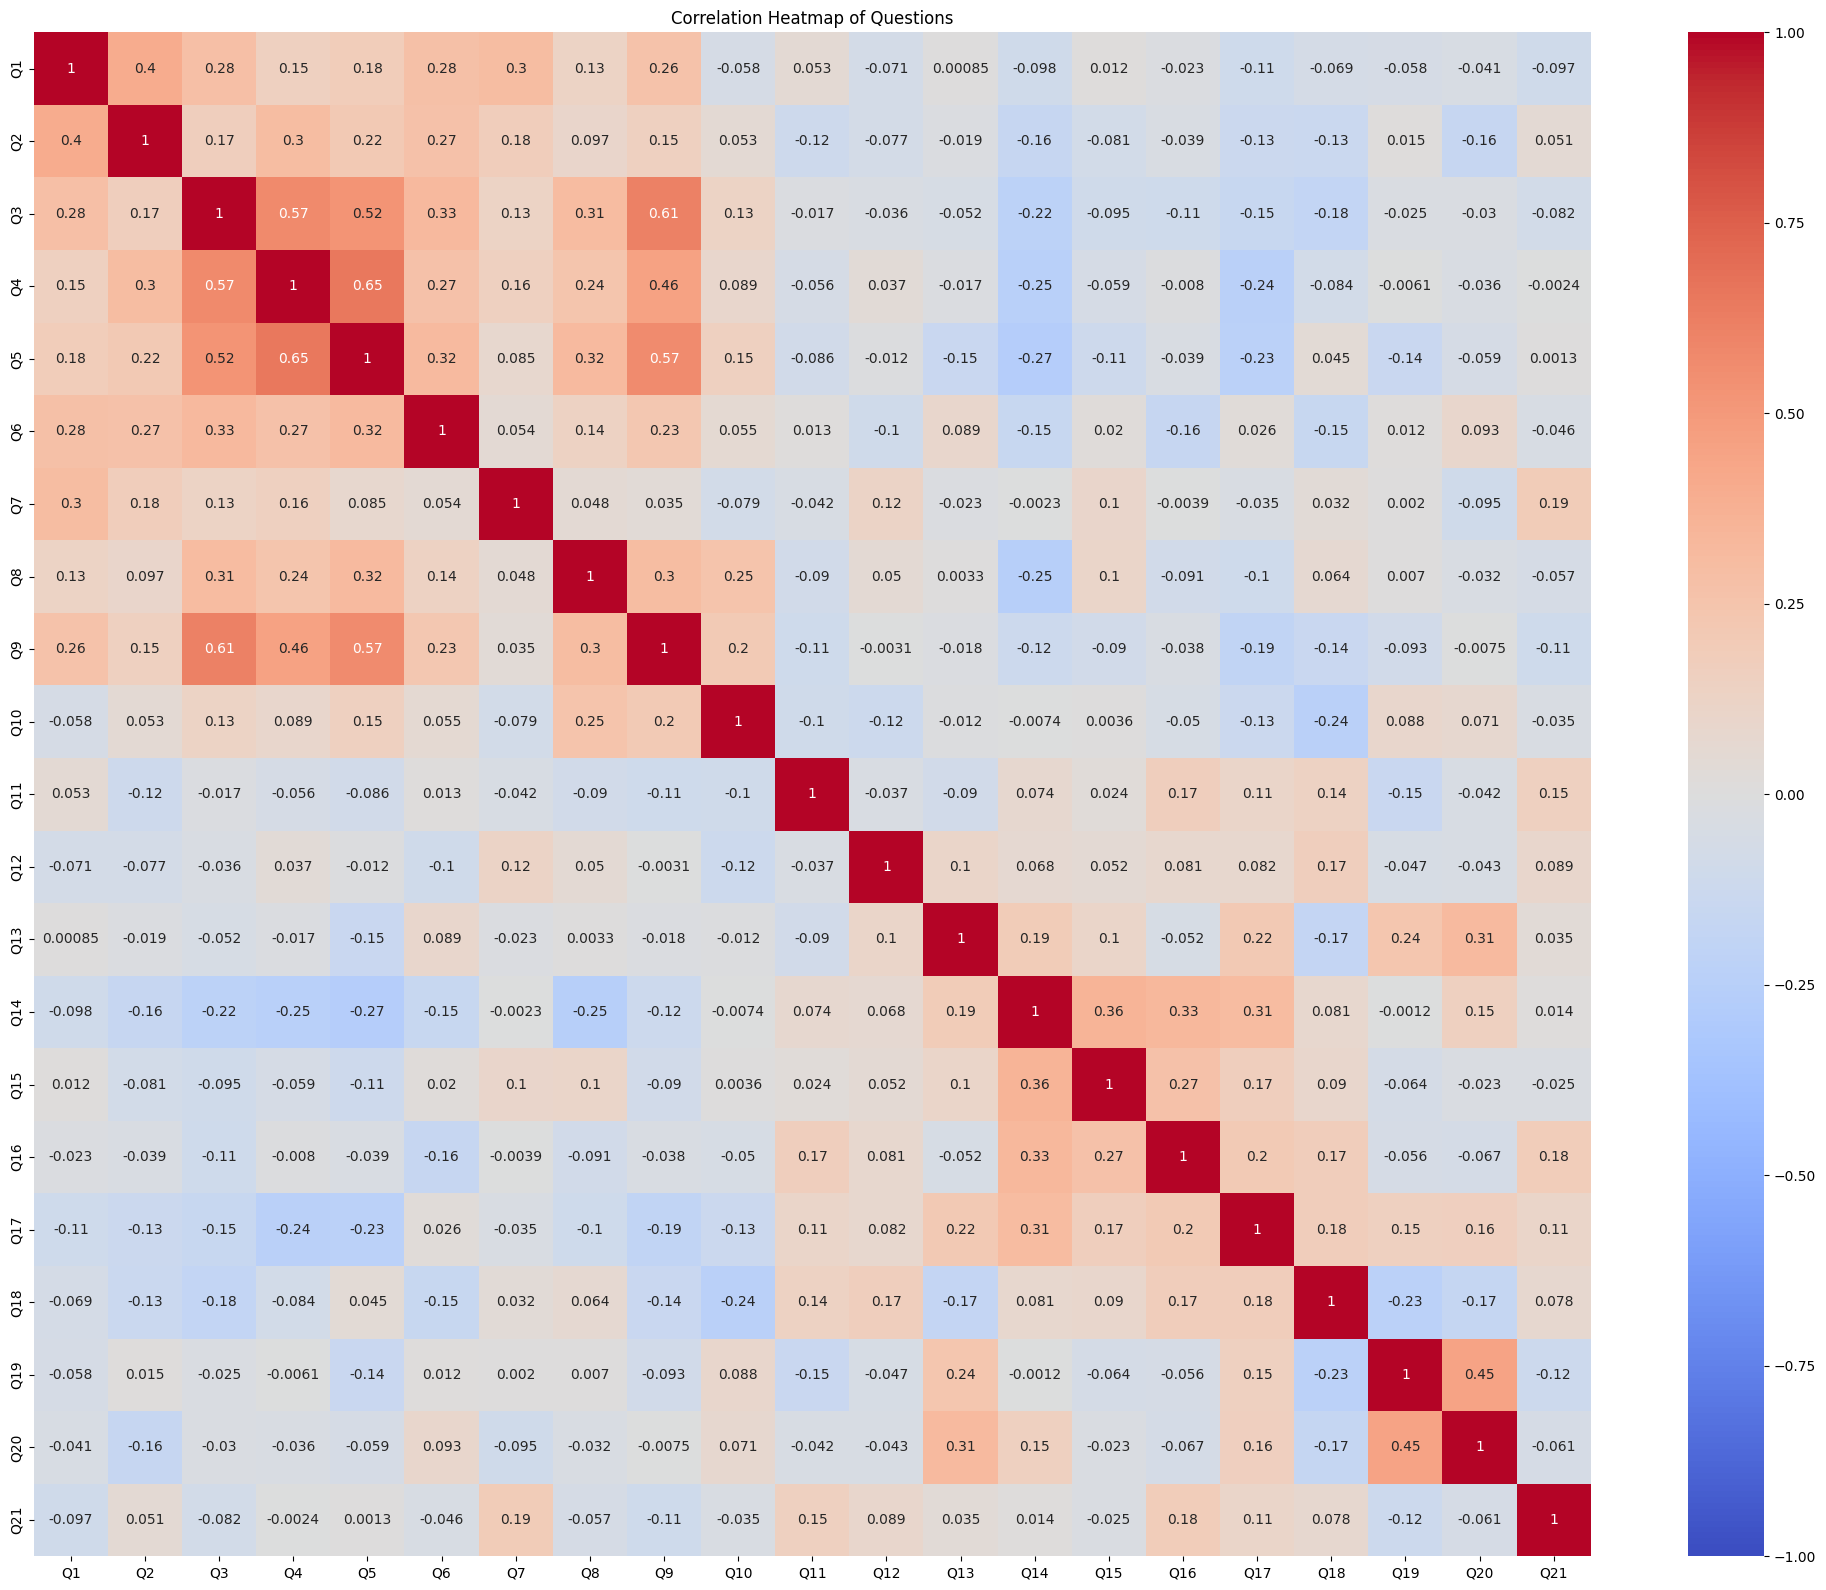

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

correlation_matrix = pd.DataFrame(true_labels).corr()

plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0,
            xticklabels=[f'Q{i+1}' for i in range(21)],
            yticklabels=[f'Q{i+1}' for i in range(21)])
plt.title('Correlation Heatmap of Questions')
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
plt.show()

F1 Scores Bar Plot:

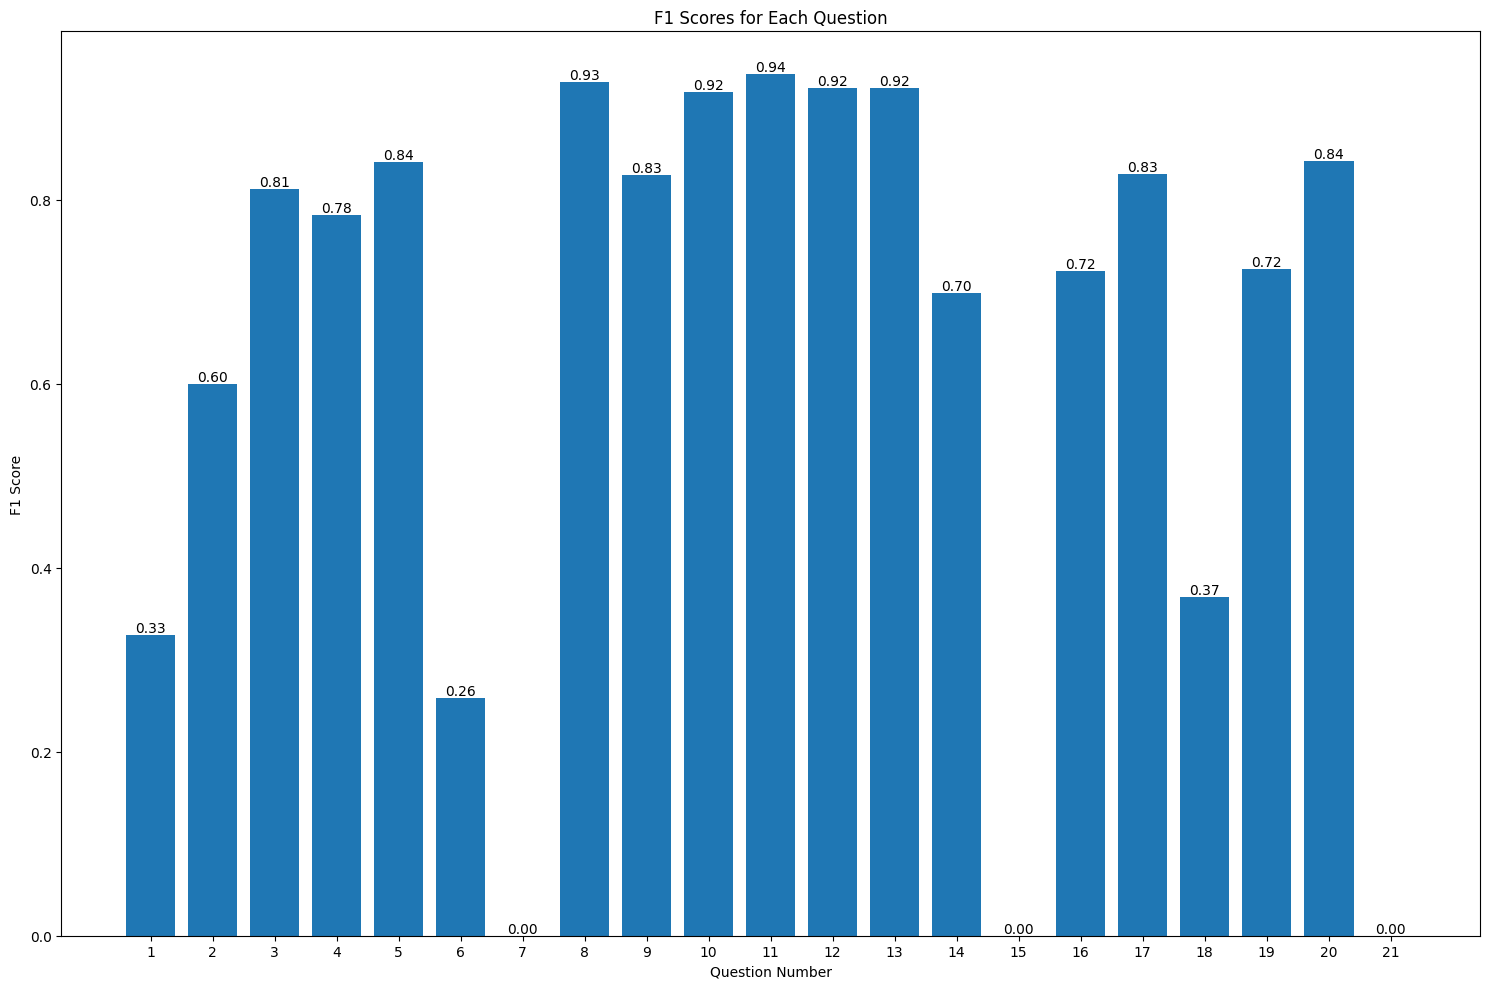

In [19]:
f1_scores = [f1_score(true_labels[:, i], predictions[:, i]) for i in range(21)]

plt.figure(figsize=(15, 10))
bars = plt.bar(range(1, 22), f1_scores)
plt.xlabel('Question Number')
plt.ylabel('F1 Score')
plt.title('F1 Scores for Each Question')
plt.xticks(range(1, 22))

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.savefig('f1_scores_barplot.png')
plt.show()

Precision-Recall Curve for Each Question:

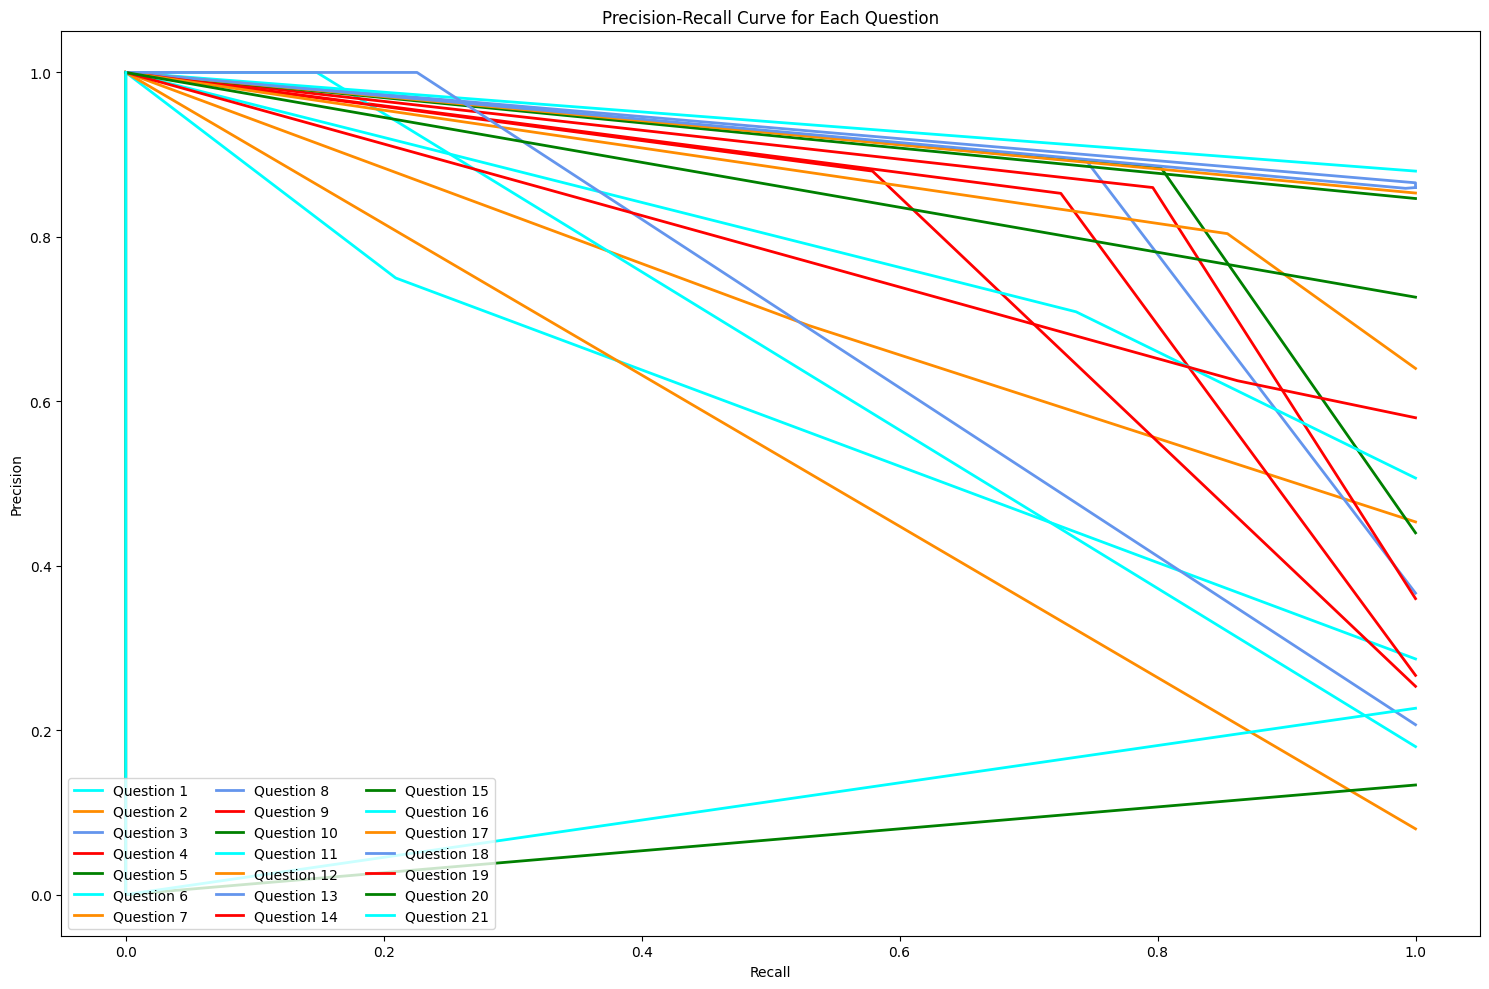

In [20]:
from sklearn.metrics import precision_recall_curve
from itertools import cycle

plt.figure(figsize=(15, 10))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])

for i, color in zip(range(21), colors):
    precision, recall, _ = precision_recall_curve(true_labels[:, i], predictions[:, i])
    plt.plot(recall, precision, color=color, lw=2,
             label=f'Question {i+1}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Question')
plt.legend(loc="lower left", ncol=3)
plt.tight_layout()
plt.savefig('precision_recall_curves.png')
plt.show()

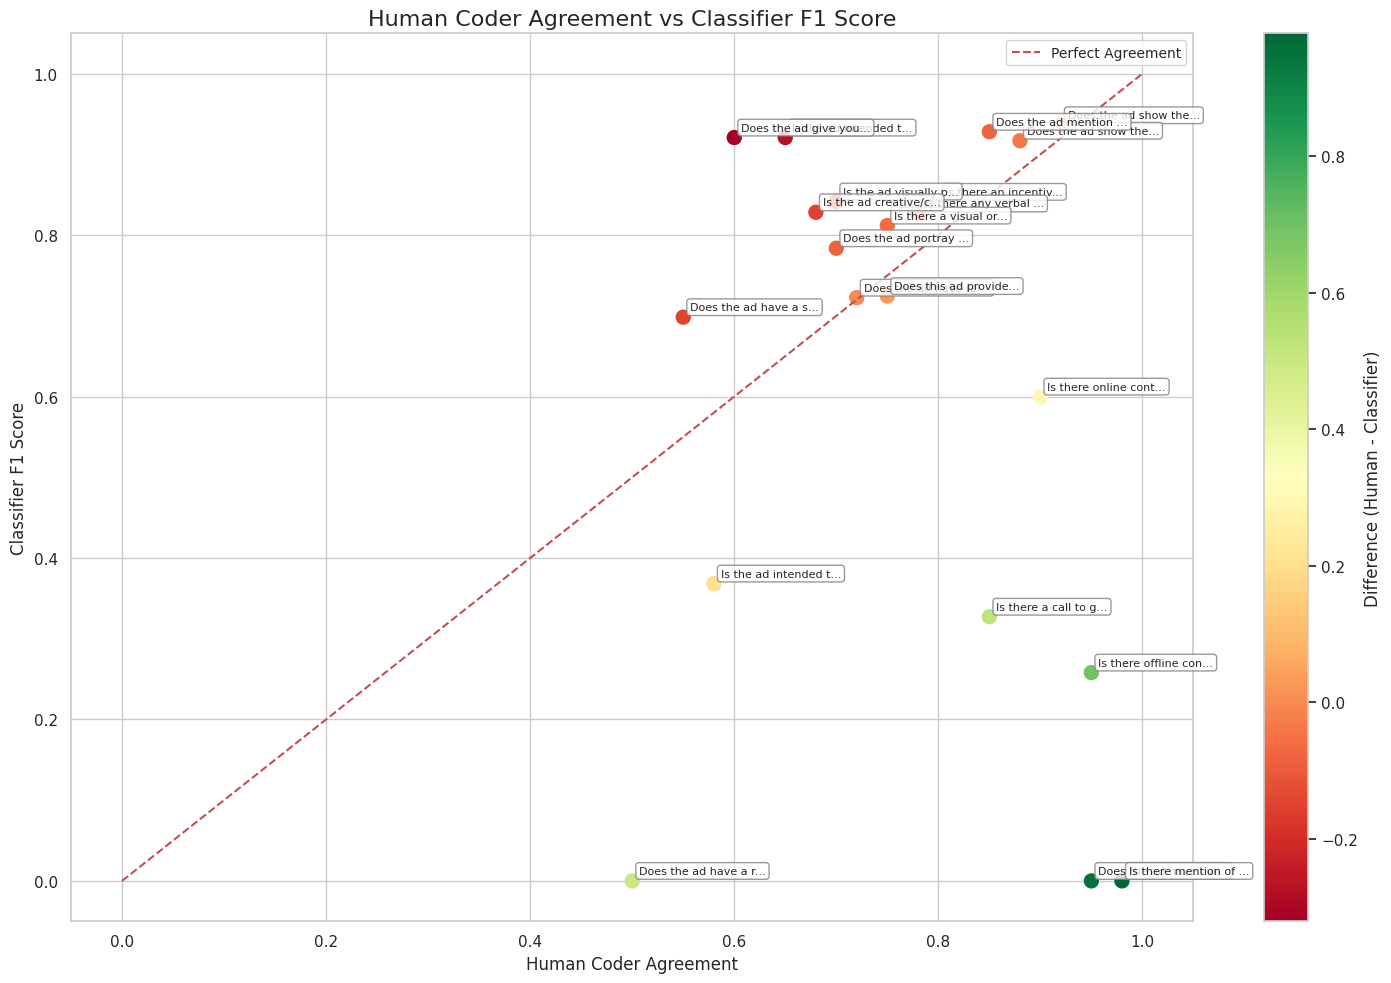

Questions where classifier outperforms human agreement:
                                             Question  Human Agreement  \
19                       Is the ad visually pleasing?             0.70   
16                         Is the ad creative/clever?             0.68   
13  Does the ad have a story arc, with a beginning...             0.55   
11  Is the ad intended to affect the viewer emotio...             0.65   
12  Does the ad give you a positive feeling about ...             0.60   

    F1 Score  Difference  
19    0.8417     -0.1417  
16    0.8283     -0.1483  
13    0.6984     -0.1484  
11    0.9209     -0.2709  
12    0.9209     -0.3209  

Questions where human agreement significantly exceeds classifier performance:
                                             Question  Human Agreement  \
17  Is the ad intended to be funny? (Note: You may...             0.58   
1   Is there online contact information provided (...             0.90   
14  Does the ad have a reversal of f

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

f1_scores = [0.3273, 0.6000, 0.8119, 0.7838, 0.8413, 0.2581, 0.0000, 0.9281, 0.8269, 0.9362,
             0.9170, 0.9209, 0.9209, 0.6984, 0.0000, 0.7226, 0.8283, 0.3684, 0.7246, 0.8417, 0.0000]

human_agreement = [0.85, 0.90, 0.75, 0.70, 0.80, 0.95, 0.98, 0.85, 0.78, 0.92,
                   0.88, 0.65, 0.60, 0.55, 0.50, 0.72, 0.68, 0.58, 0.75, 0.70, 0.95]

# Create a DataFrame
df = pd.DataFrame({
    'Question': questions,
    'F1 Score': f1_scores,
    'Human Agreement': human_agreement
})

# Calculate the difference between human agreement and F1 score
df['Difference'] = df['Human Agreement'] - df['F1 Score']

# Sort by the absolute difference
df = df.iloc[np.abs(df['Difference']).argsort()]

# Create the plot
plt.figure(figsize=(15, 10))
sns.set(style="whitegrid")

# Plot human agreement and F1 scores
sns.scatterplot(x='Human Agreement', y='F1 Score', data=df, s=100)

# Add labels for each point
for i, row in df.iterrows():
    plt.annotate(row['Question'][:20] + '...',
                 (row['Human Agreement'], row['F1 Score']),
                 xytext=(5, 5), textcoords='offset points', fontsize=8,
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Plot the diagonal line
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Agreement')

plt.title('Human Coder Agreement vs Classifier F1 Score', fontsize=16)
plt.xlabel('Human Coder Agreement', fontsize=12)
plt.ylabel('Classifier F1 Score', fontsize=12)
plt.legend(fontsize=10)

# Add a colorbar to show the difference
scatter = plt.scatter(df['Human Agreement'], df['F1 Score'], c=df['Difference'], cmap='RdYlGn', s=100)
plt.colorbar(scatter, label='Difference (Human - Classifier)')

plt.tight_layout()
plt.show()

# Print analysis
print("Questions where classifier outperforms human agreement:")
print(df[df['Difference'] < -0.1][['Question', 'Human Agreement', 'F1 Score', 'Difference']])

print("\nQuestions where human agreement significantly exceeds classifier performance:")
print(df[df['Difference'] > 0.1][['Question', 'Human Agreement', 'F1 Score', 'Difference']])

print("\nQuestions with lowest overall performance (human agreement and F1 score):")
df['Overall Performance'] = (df['Human Agreement'] + df['F1 Score']) / 2
print(df.nsmallest(5, 'Overall Performance')[['Question', 'Human Agreement', 'F1 Score', 'Overall Performance']])

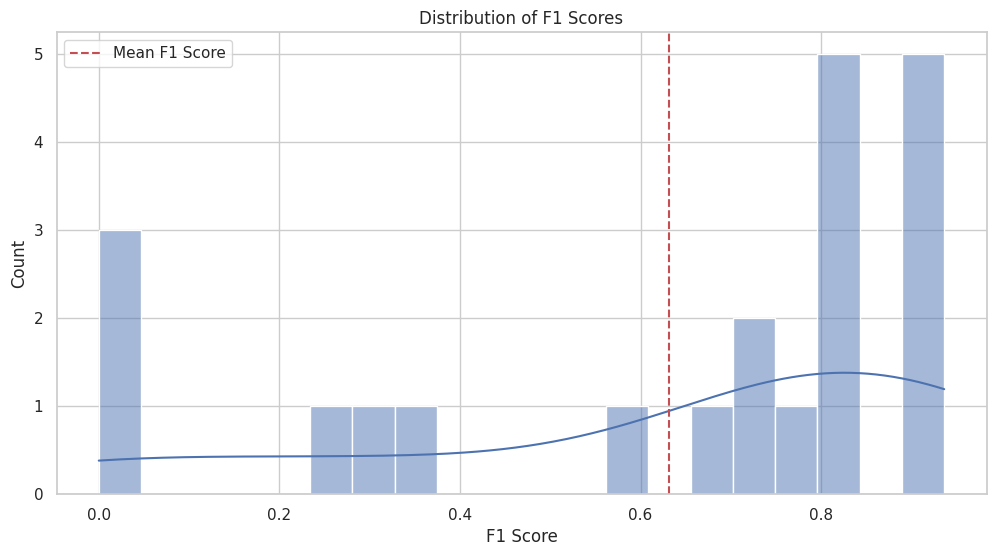

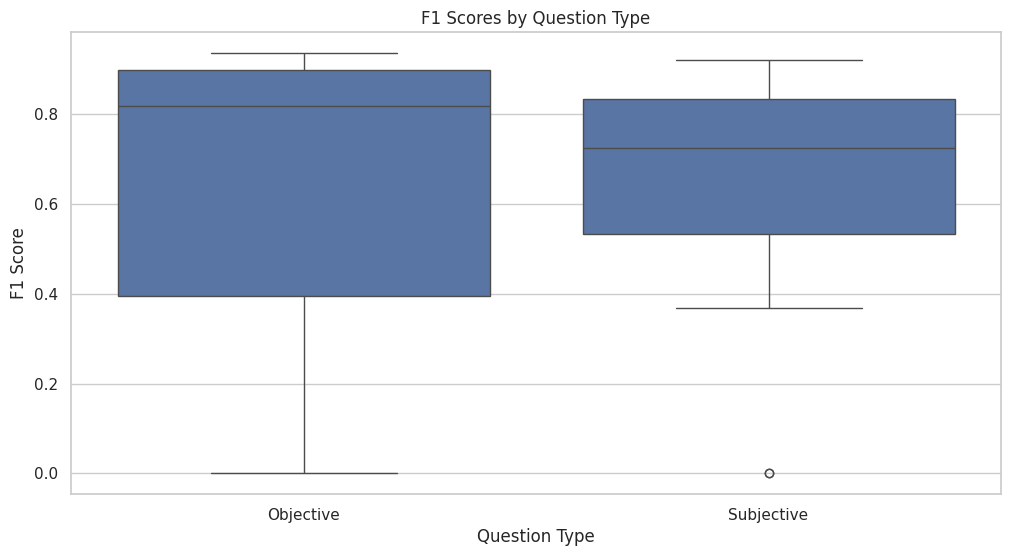


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='F1 Score', y='Question', data=top_bottom, palette='RdYlGn')

  plt.tight_layout()



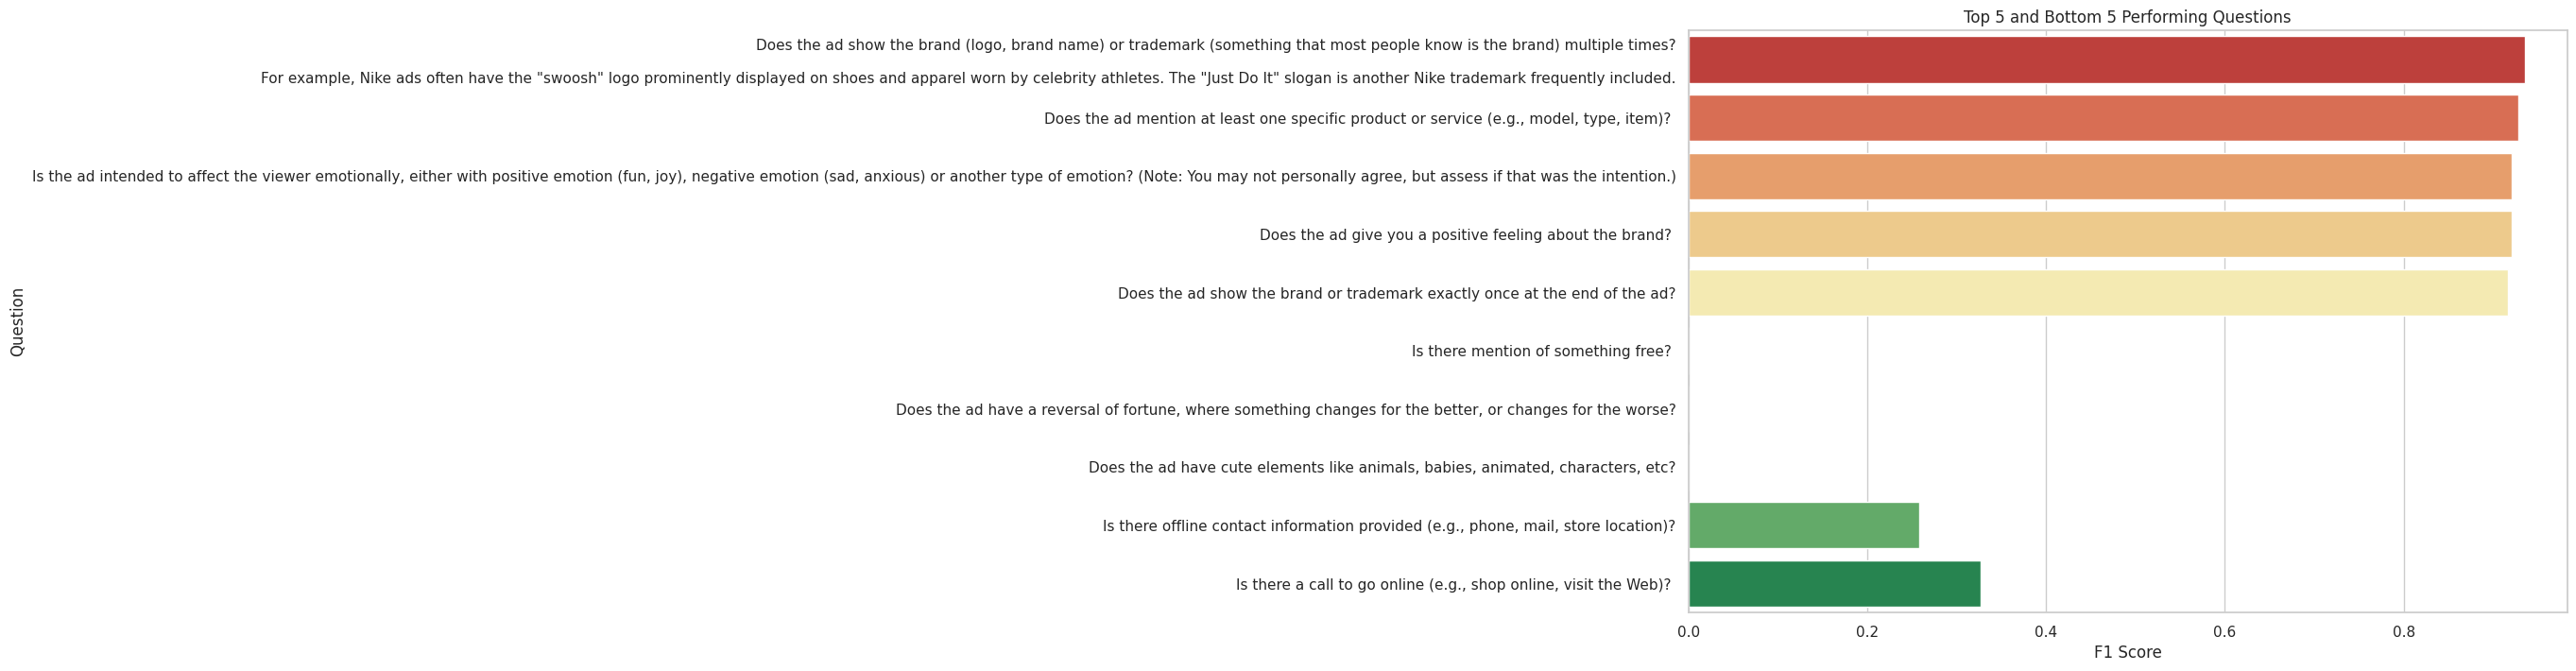

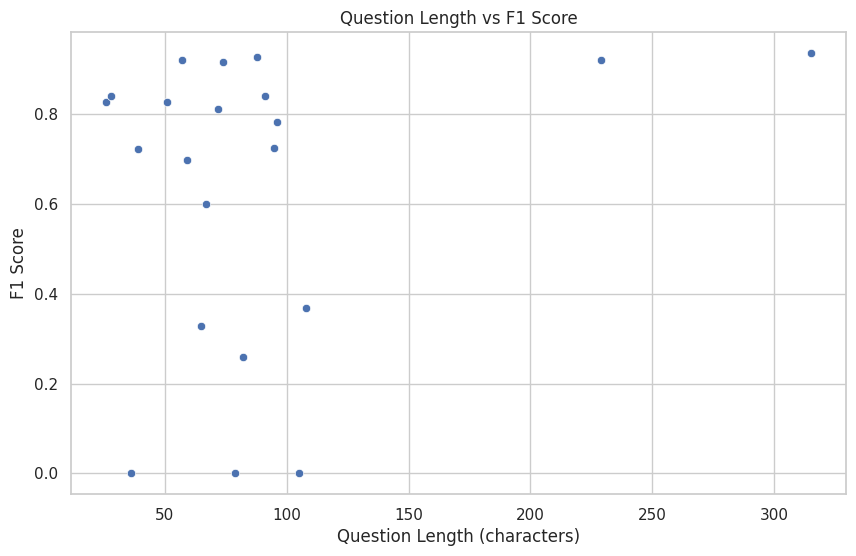

        F1 Score  Question Length
count  21.000000        21.000000
mean    0.631257        88.666667
std     0.329445        66.884478
min     0.000000        26.000000
25%     0.368400        57.000000
50%     0.783800        74.000000
75%     0.841700        95.000000
max     0.936200       315.000000

Questions with F1 Score of 0:
['Is there mention of something free? ', 'Does the ad have a reversal of fortune, where something changes for the better, or changes for the worse?', 'Does the ad have cute elements like animals, babies, animated, characters, etc?']


In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


f1_scores = [0.3273, 0.6000, 0.8119, 0.7838, 0.8413, 0.2581, 0.0000, 0.9281, 0.8269, 0.9362,
             0.9170, 0.9209, 0.9209, 0.6984, 0.0000, 0.7226, 0.8283, 0.3684, 0.7246, 0.8417, 0.0000]

# Create a DataFrame
df = pd.DataFrame({
    'Question': questions,
    'F1 Score': f1_scores
})

# 1. Distribution of F1 Scores
plt.figure(figsize=(12, 6))
sns.histplot(df['F1 Score'], bins=20, kde=True)
plt.title('Distribution of F1 Scores')
plt.xlabel('F1 Score')
plt.ylabel('Count')
plt.axvline(df['F1 Score'].mean(), color='r', linestyle='--', label='Mean F1 Score')
plt.legend()
plt.show()

# 2. F1 Scores by Question Type
df['Question Type'] = df['Question'].apply(lambda x: 'Objective' if any(keyword in x.lower() for keyword in ['is there', 'does the ad mention', 'does the ad show']) else 'Subjective')
plt.figure(figsize=(12, 6))
sns.boxplot(x='Question Type', y='F1 Score', data=df)
plt.title('F1 Scores by Question Type')
plt.show()

# 3. Top and Bottom Performing Questions
top_bottom = pd.concat([df.nlargest(5, 'F1 Score'), df.nsmallest(5, 'F1 Score')])
plt.figure(figsize=(12, 8))
sns.barplot(x='F1 Score', y='Question', data=top_bottom, palette='RdYlGn')
plt.title('Top 5 and Bottom 5 Performing Questions')
plt.xlabel('F1 Score')
plt.tight_layout()
plt.show()

# 4. Correlation between question length and F1 Score
df['Question Length'] = df['Question'].str.len()
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Question Length', y='F1 Score', data=df)
plt.title('Question Length vs F1 Score')
plt.xlabel('Question Length (characters)')
plt.ylabel('F1 Score')
plt.show()

# Print summary statistics
print(df.describe())
print("\nQuestions with F1 Score of 0:")
print(df[df['F1 Score'] == 0]['Question'].tolist())

Model Performance Radar Chart:

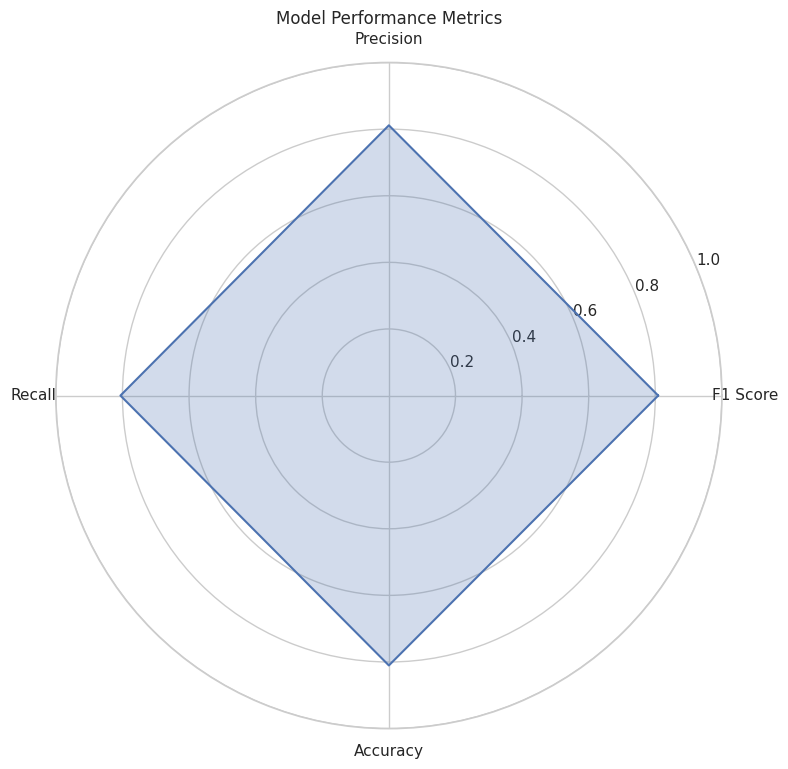

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Use the overall metrics from your results
metrics = ['F1 Score', 'Precision', 'Recall', 'Accuracy']
values = [0.8088, 0.8115, 0.8061, 0.8104]  # These are the values from your image

# Create the radar chart
angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False)
values = np.concatenate((values, [values[0]]))  # Repeat the first value to close the polygon
angles = np.concatenate((angles, [angles[0]]))  # Repeat the first angle to close the polygon

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))
ax.plot(angles, values)
ax.fill(angles, values, alpha=0.25)
ax.set_thetagrids(angles[:-1] * 180/np.pi, metrics)
ax.set_title("Model Performance Metrics")
ax.set_ylim(0, 1)
plt.tight_layout()
plt.savefig('model_performance_radar.png')
plt.show()

Question Difficulty Bubble Chart:

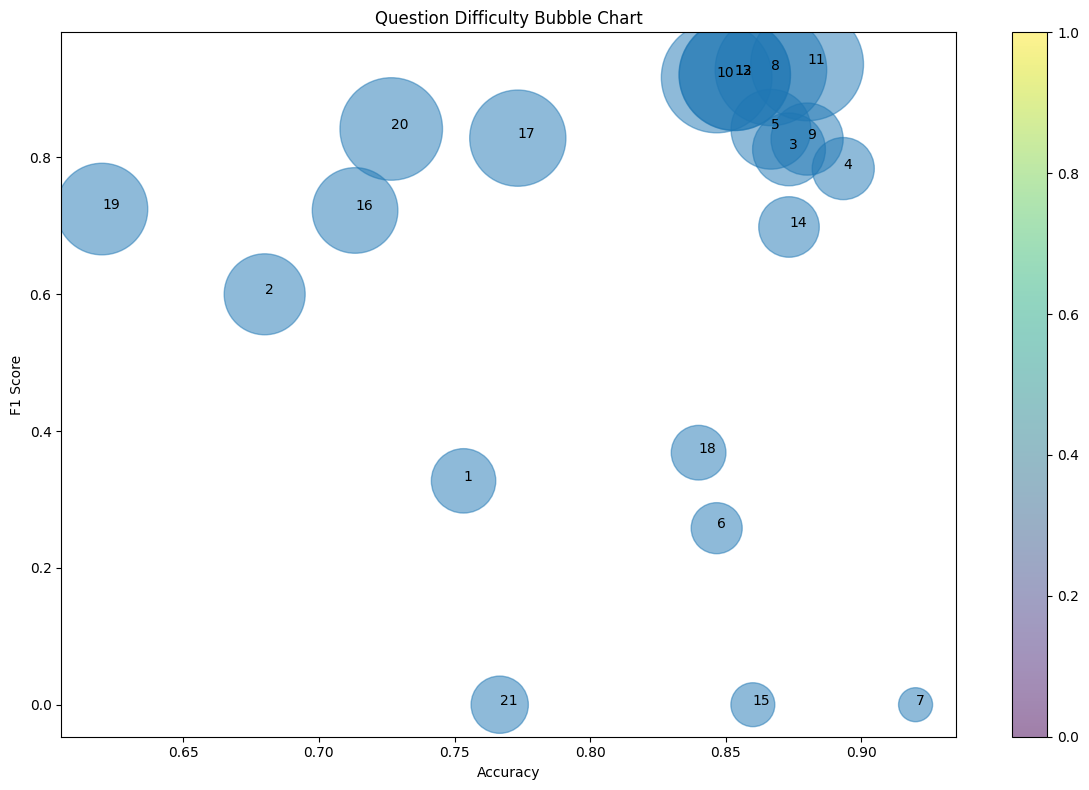

In [31]:
accuracies = [accuracy_score(true_labels[:, i], predictions[:, i]) for i in range(21)]
f1_scores = [f1_score(true_labels[:, i], predictions[:, i]) for i in range(21)]
support = true_labels.sum(axis=0)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(accuracies, f1_scores, s=support*50, alpha=0.5)

for i, txt in enumerate(range(1, 22)):
    plt.annotate(txt, (accuracies[i], f1_scores[i]))

plt.xlabel('Accuracy')
plt.ylabel('F1 Score')
plt.title('Question Difficulty Bubble Chart')
plt.colorbar(scatter)
plt.tight_layout()
plt.savefig('question_difficulty_bubble.png')
plt.show()

Human Coder Agreement Histogram:

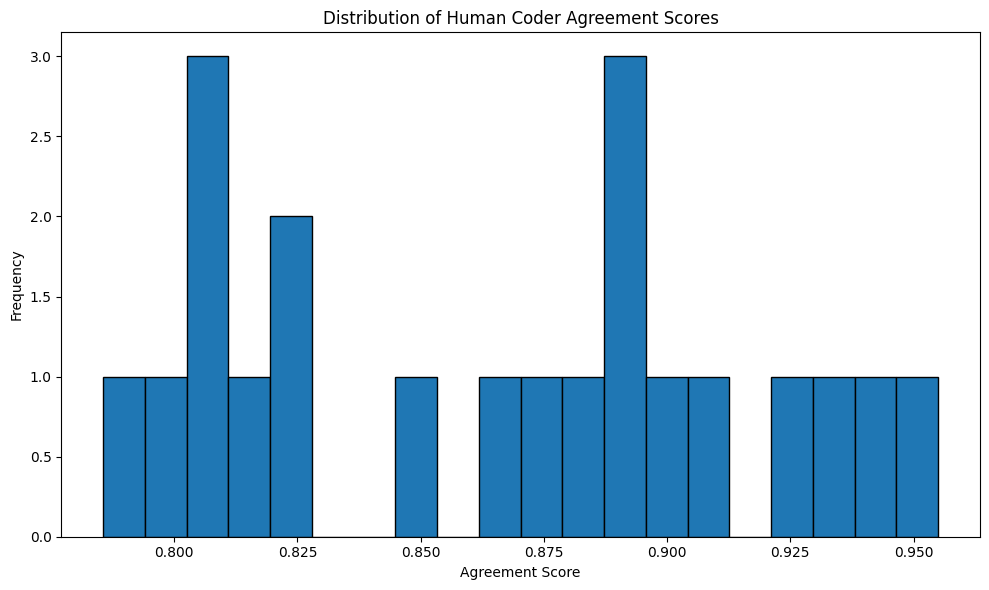

In [33]:
def calculate_agreement(row):
    return (row == row.mode().iloc[0]).mean()

agreement_scores = ground_truth.groupby('creative_data_id')[questions].apply(calculate_agreement).mean()

plt.figure(figsize=(10, 6))
plt.hist(agreement_scores, bins=20, edgecolor='black')
plt.xlabel('Agreement Score')
plt.ylabel('Frequency')
plt.title('Distribution of Human Coder Agreement Scores')
plt.tight_layout()
plt.savefig('human_coder_agreement_hist.png')
plt.show()

Model vs. Human Performance Comparison:

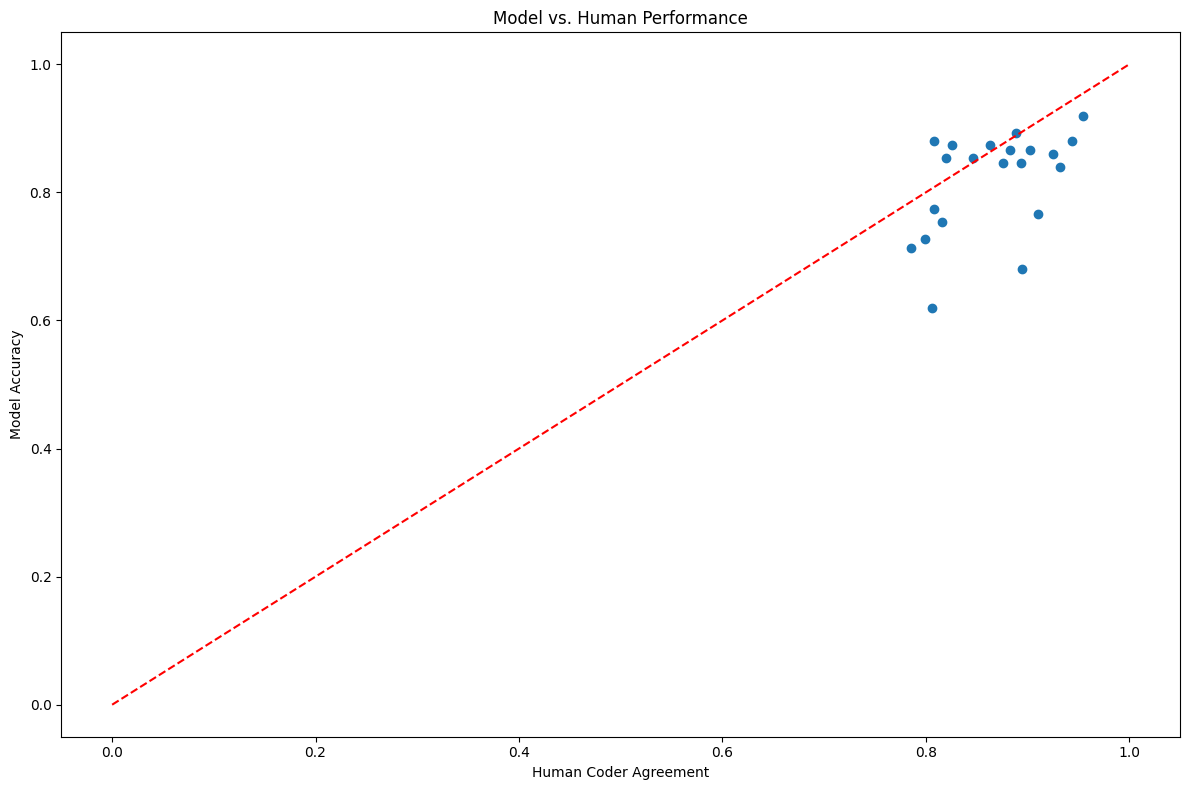

In [34]:
model_accuracy = [accuracy_score(true_labels[:, i], predictions[:, i]) for i in range(21)]
human_agreement = agreement_scores

plt.figure(figsize=(12, 8))
plt.scatter(human_agreement, model_accuracy)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Human Coder Agreement')
plt.ylabel('Model Accuracy')
plt.title('Model vs. Human Performance')
plt.tight_layout()
plt.savefig('model_vs_human_performance.png')
plt.show()

Misclassification Analysis:

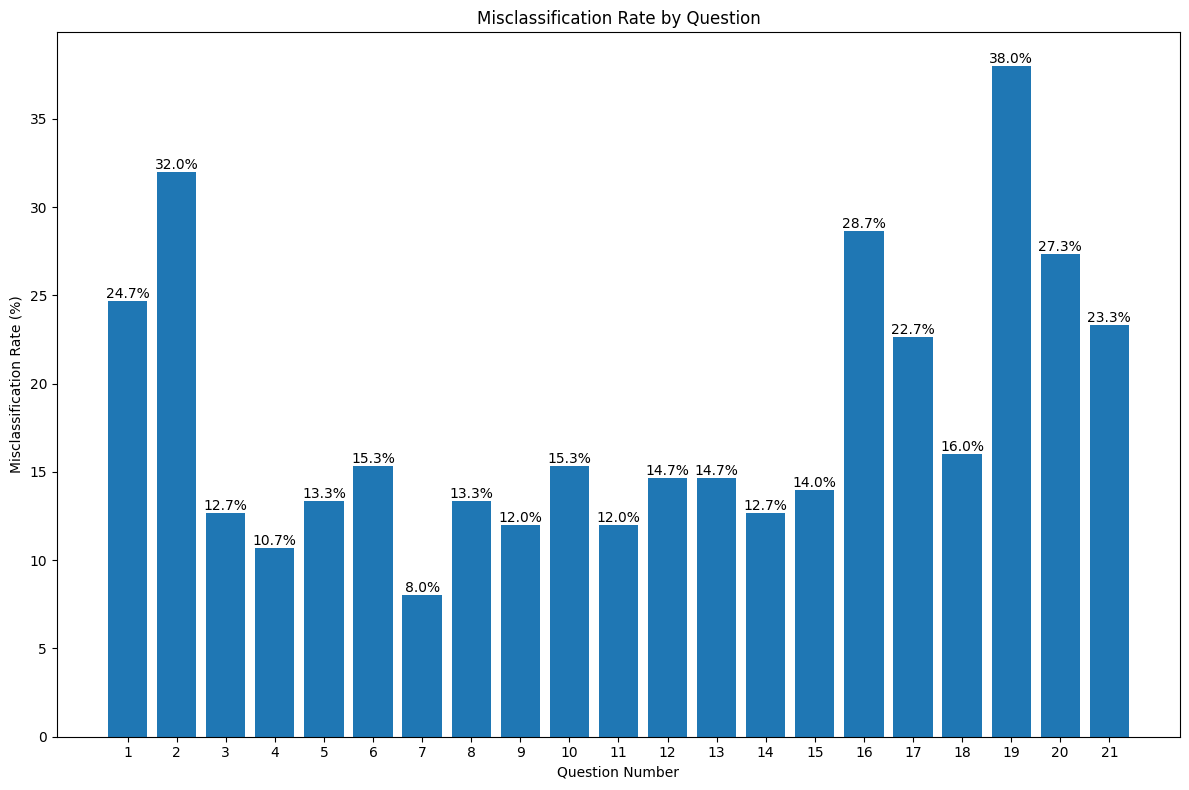

In [36]:
misclassification_rates = ((predictions != true_labels).sum(axis=0) / len(predictions)) * 100

plt.figure(figsize=(12, 8))
bars = plt.bar(range(1, 22), misclassification_rates)
plt.xlabel('Question Number')
plt.ylabel('Misclassification Rate (%)')
plt.title('Misclassification Rate by Question')
plt.xticks(range(1, 22))

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%',
             ha='center', va='bottom')

plt.tight_layout()
plt.savefig('misclassification_analysis.png')
plt.show()